# Anomaly Detection Analysis

## Preproccess

### Import Lib

In [9]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json,os,glob
from IPython.core.pylabtools import figsize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

#import solve_cudnn
#solve_cudnn.solve_cudnn_error()

figsize(15, 7) 

### Utils

In [10]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime'):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(df.iloc[:].index,Values[:bound, group],linewidth=3)
        plt.plot(df.iloc[:].index,Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], loc='right')
        plt.grid()
        plt.xticks(rotation=45)
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [11]:
def gen_dataset(data,y_column_list,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, y_column_list ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    
    if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
    feb_index = data.loc['2021-02'].index.shape[0]
    
    #Y Columns
    y_column=[0,1,2,3,4,5,6,7]
    
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data_scaled = scaler.fit_transform(data)     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0,1))
        data_scaled = scaler.fit_transform(data)     

    #training-test split
    training_set = data_scaled[:feb_index,:]
    testing_set = data_scaled[feb_index:,:]
    print("Train set:{}".format(training_set.shape))
    print("Test set:{}".format(testing_set.shape))
    
    #generate dataset
    train_X,train_y = gen_dataset(training_set,y_column,X_win_size,y_win_size)
    test_X,test_y = gen_dataset(testing_set,y_column,X_win_size,y_win_size)

    #return  
    
    return train_X,train_y,test_X,test_y,scaler,data_scaled

### Read Data

In [15]:
root_path = r"E:\Server_mantain\Zabbix_Online_detection\Dataset"
FILENAME1 = "5v_180days.csv"
data_5v_path = os.path.join(root_path,"OPTIdata",FILENAME1)

### Split Usage and Quene

In [209]:
import glob

with open(os.path.join(root_path,"OPTIdata","names.txt"),"r") as f:
    names = f.read().split("\n")
    
def get_index_num(df,col_names):
    
    num = []
    for col in col_names:
        num.append(df[df['name']==col].shape[0])
    num.sort()
    return num[0]
    
for csv in glob.glob(os.path.join(root_path,"OPTIdata","*_180days.csv")):
    
    dict_5v = {}
    dict_5v_quene = {}
    temp_shape = []
    data_name = csv.split("\\")[-1].split("_")[0]
    data_5v = read_data(csv,dt_name='datetime')
    
    print(names[4:])
    ind_usage = get_index_num(data_5v,names[4:])
    ind_quene = get_index_num(data_5v,names[:4])
    
    ind = data_5v[data_5v['name']==names[4]][:ind_usage].index
    ind2 = data_5v[data_5v['name']==names[0]][:ind_quene].index
    
    
    
    
    for name in names[4:]:
        #usage&freespace
        dict_5v[name+"_"+data_name] = data_5v[data_5v['name']==name].values[:ind_usage,-1]
        print(data_5v[data_5v['name']==name].values[:,-1].shape[0])
    for name in names[:4]:
        #quene
        dict_5v_quene[name+"_"+data_name] = data_5v[data_5v['name']==name].values[:ind_quene,-1]
        print(data_5v[data_5v['name']==name].values[:,-1].shape[0])
    
    concat1 = pd.DataFrame(dict_5v,index=ind)
    concat2 = pd.DataFrame(dict_5v_quene,index=ind2)
    
    concat1.to_csv(os.path.join(root_path,"OPTIdata","pre_process","{}_180day_usage.csv".format(data_name)))
    concat2.to_csv(os.path.join(root_path,"OPTIdata","pre_process","{}_180day_quene.csv".format(data_name)))

host     0
name     0
value    0
dtype: int64
host     0
name     0
value    0
dtype: int64
                                host                                  name  \
dt                                                                           
2021-09-18 09:46:30  TWKHH01OPTIPW1V                      Memory used  (%)   
2021-09-18 09:46:28  TWKHH01OPTIPW1V             Free disk space on D: (%)   
2021-09-18 09:46:27  TWKHH01OPTIPW1V             Free disk space on C: (%)   
2021-09-18 09:46:25  TWKHH01OPTIPW1V                   CPU utilization (%)   
2021-09-18 09:44:05  TWKHH01OPTIPW1V  Disk (1 D:) - Avg. Disk Queue Length   

                       value  
dt                            
2021-09-18 09:46:30  27.5247  
2021-09-18 09:46:28  70.0662  
2021-09-18 09:46:27  44.7280  
2021-09-18 09:46:25  39.4652  
2021-09-18 09:44:05   0.0000  
['Memory used  (%)', 'Free disk space on D: (%)', 'Free disk space on C: (%)', 'CPU utilization (%)']
43199
43199
43194
43199
2018
2018
2018
201

### Concat Usage & Quene Data and Add Anomaly Label

1v
host     0
name     0
value    0
dtype: int64
(90434, 5)


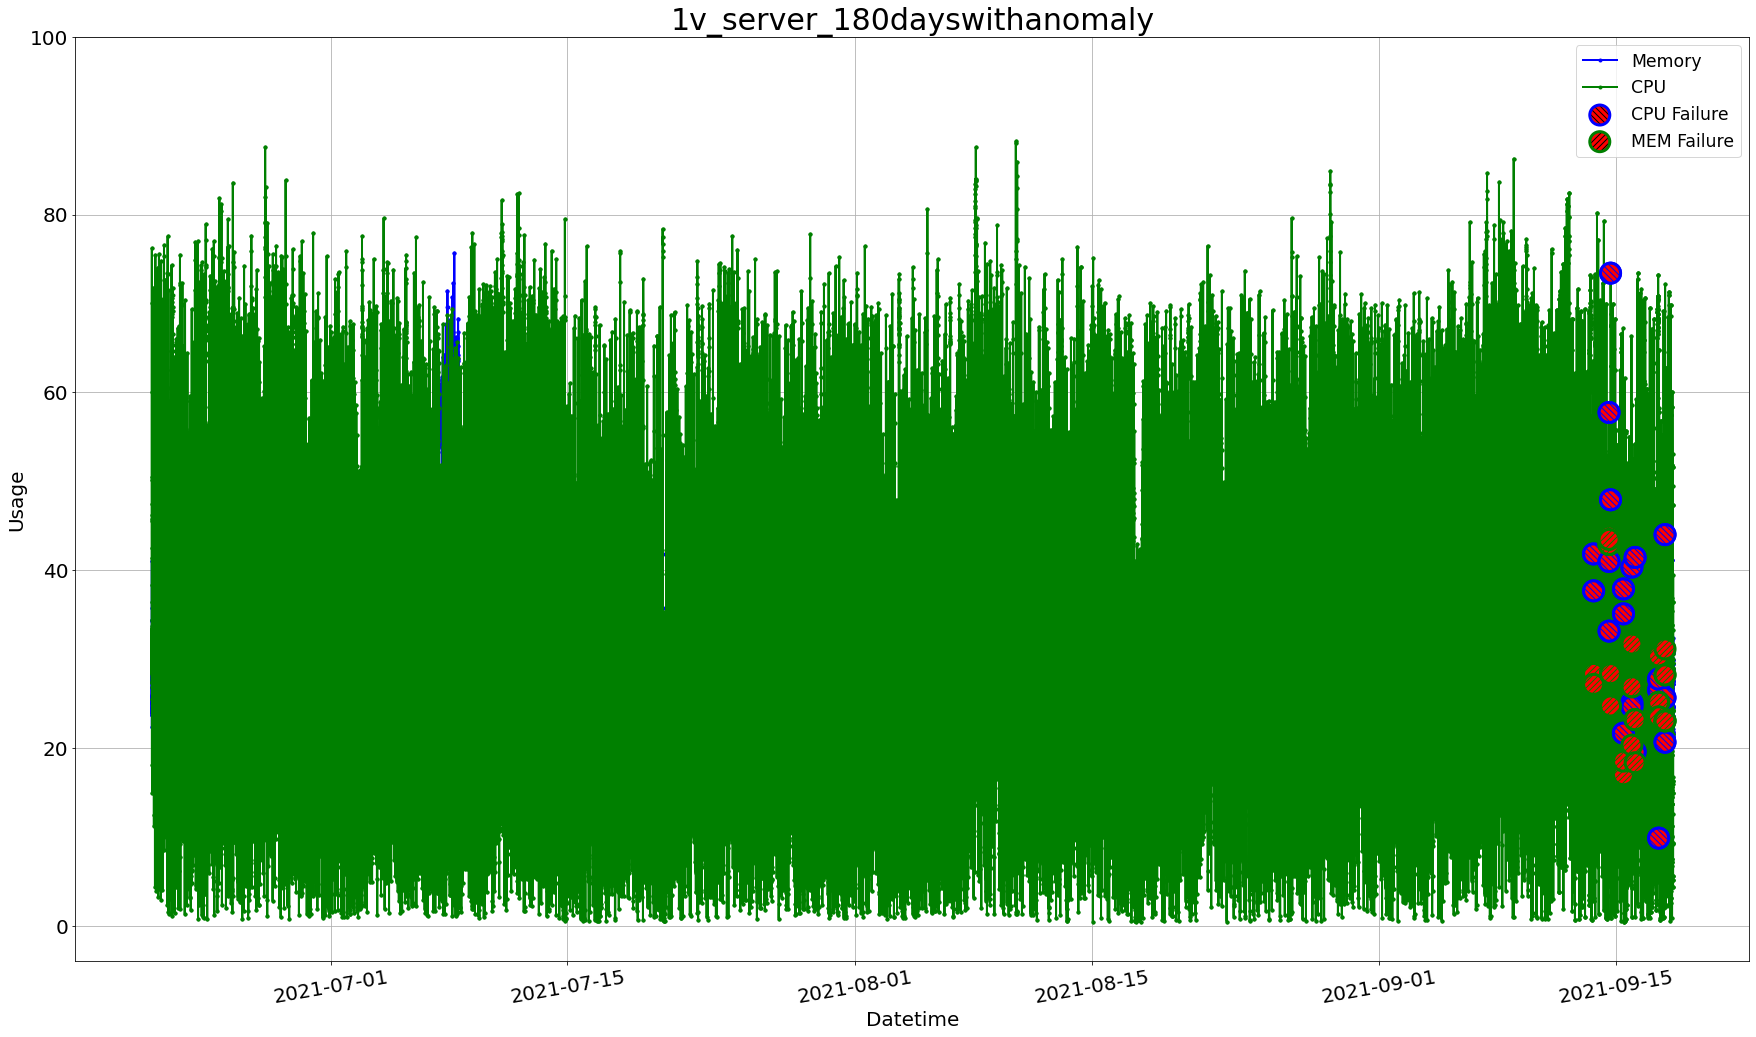

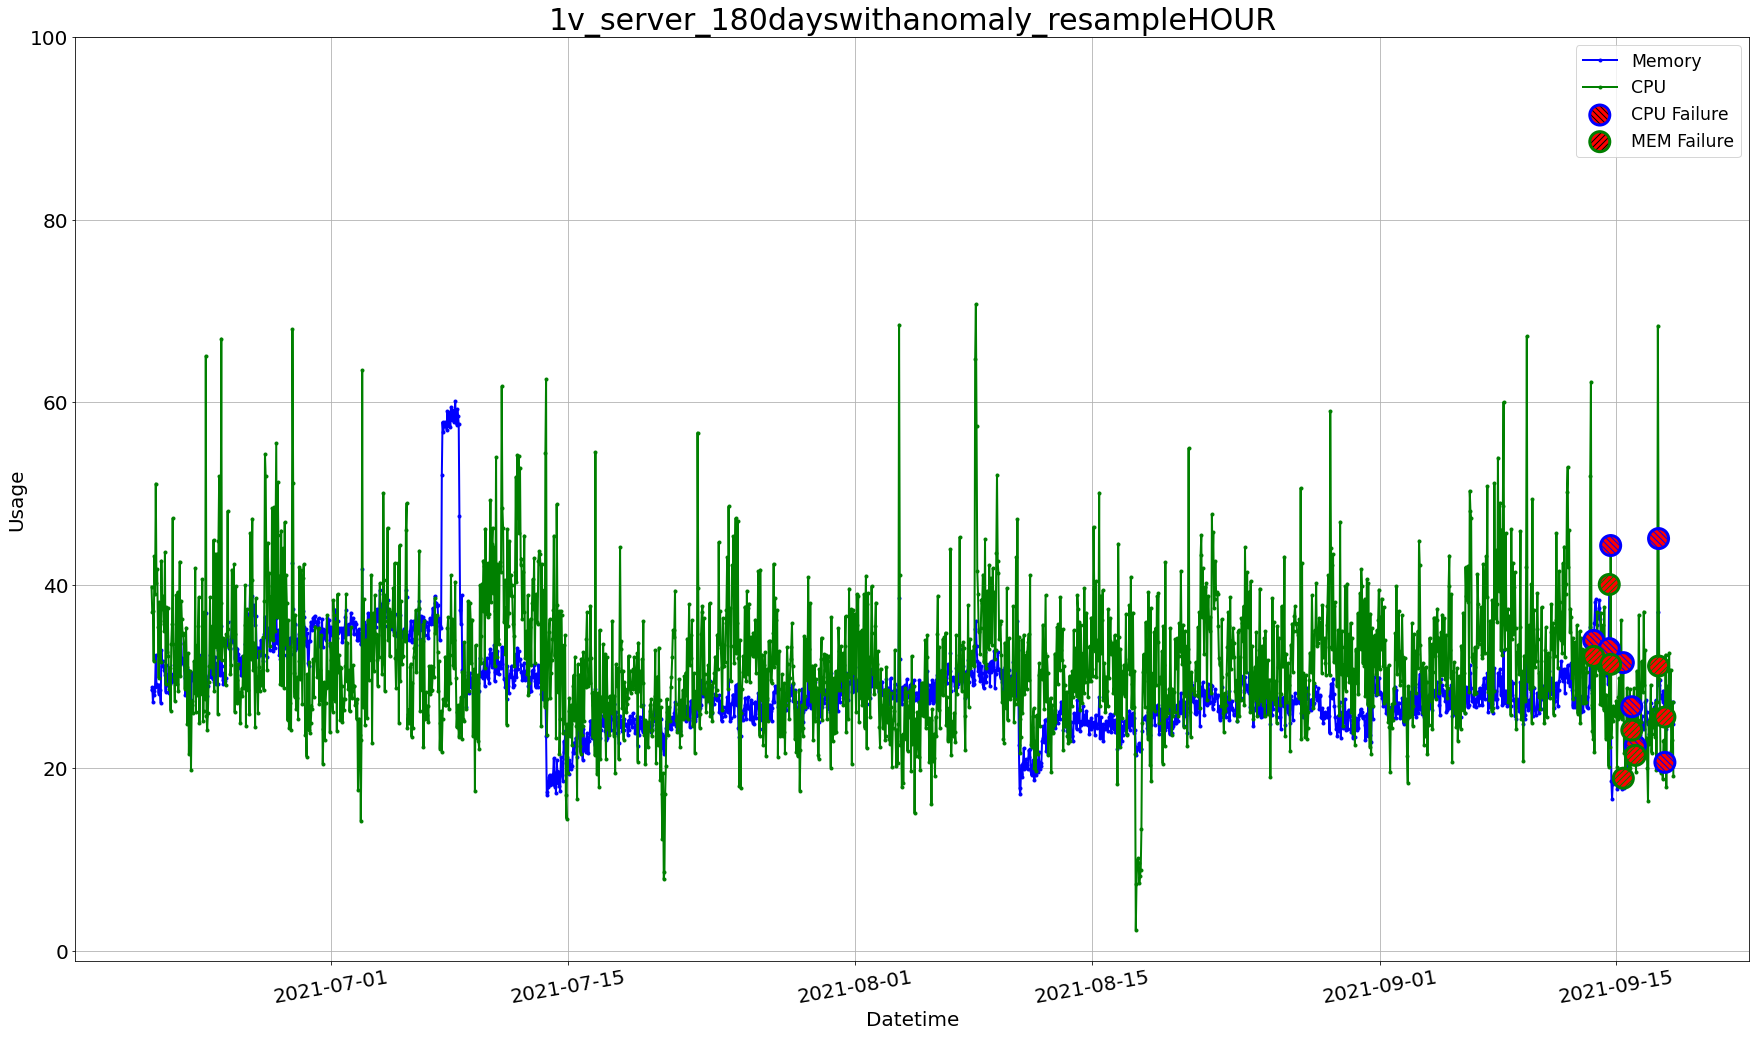

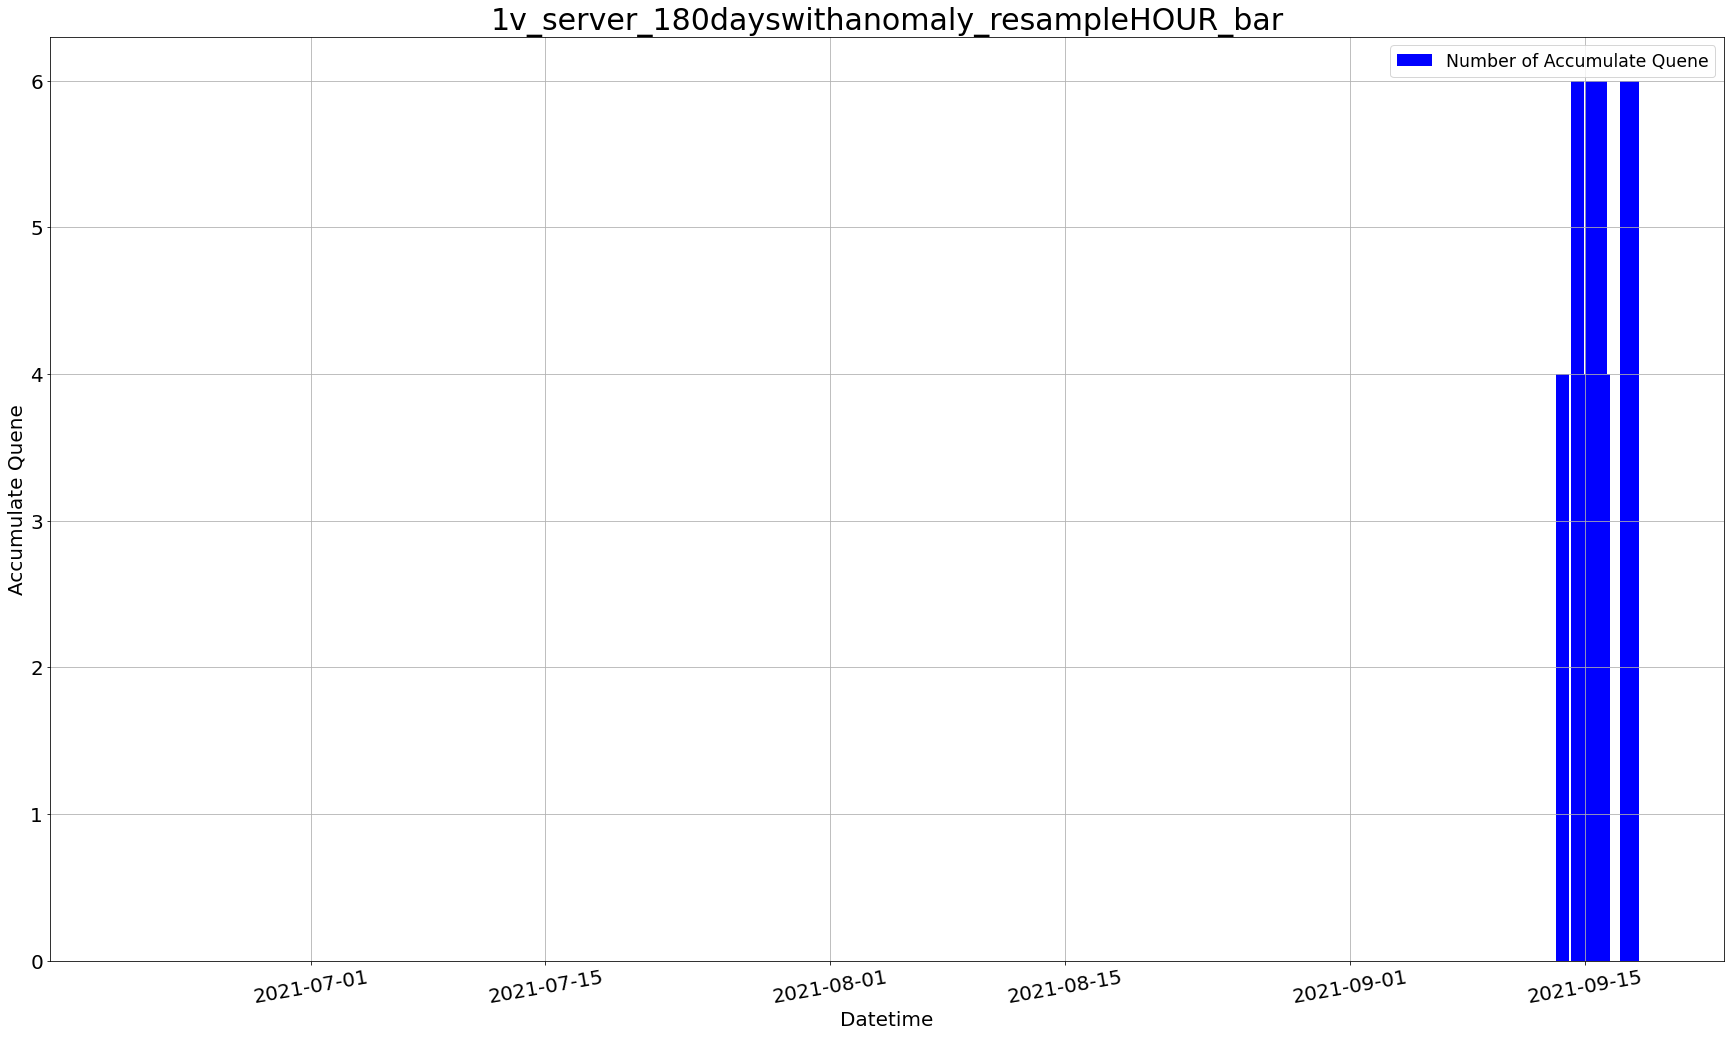

2v
host     0
name     0
value    0
dtype: int64
(90302, 5)


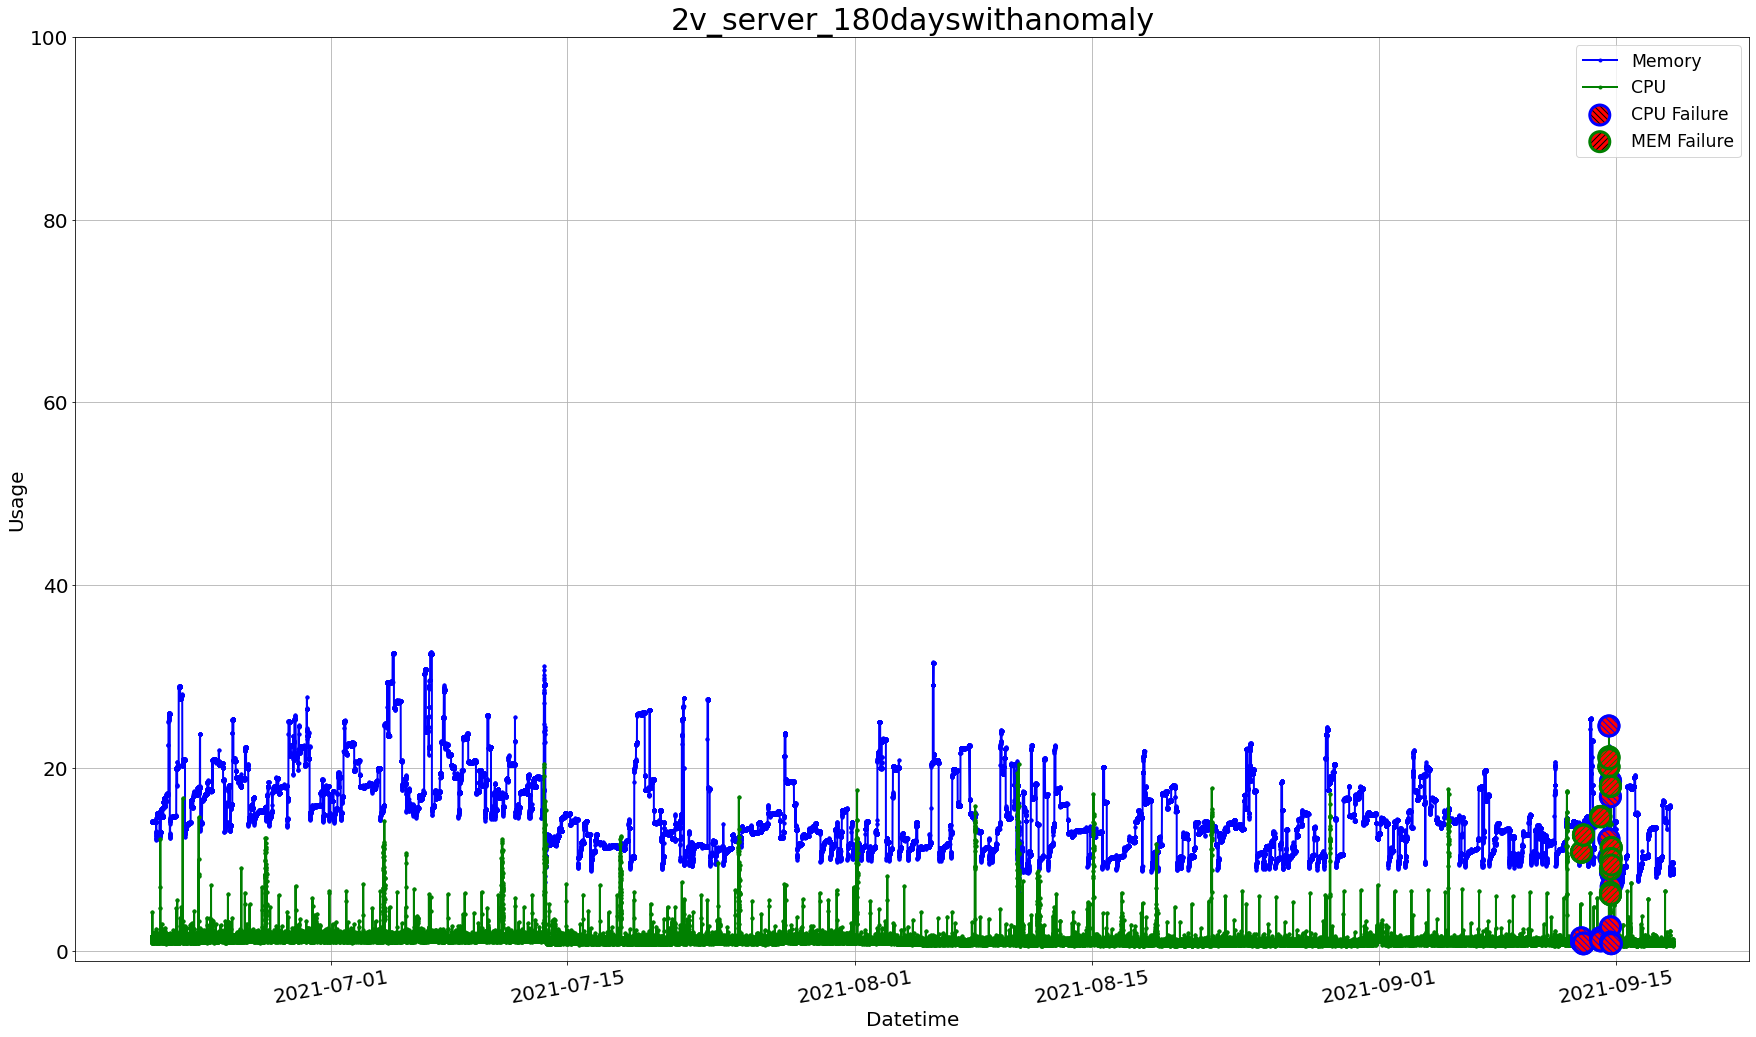

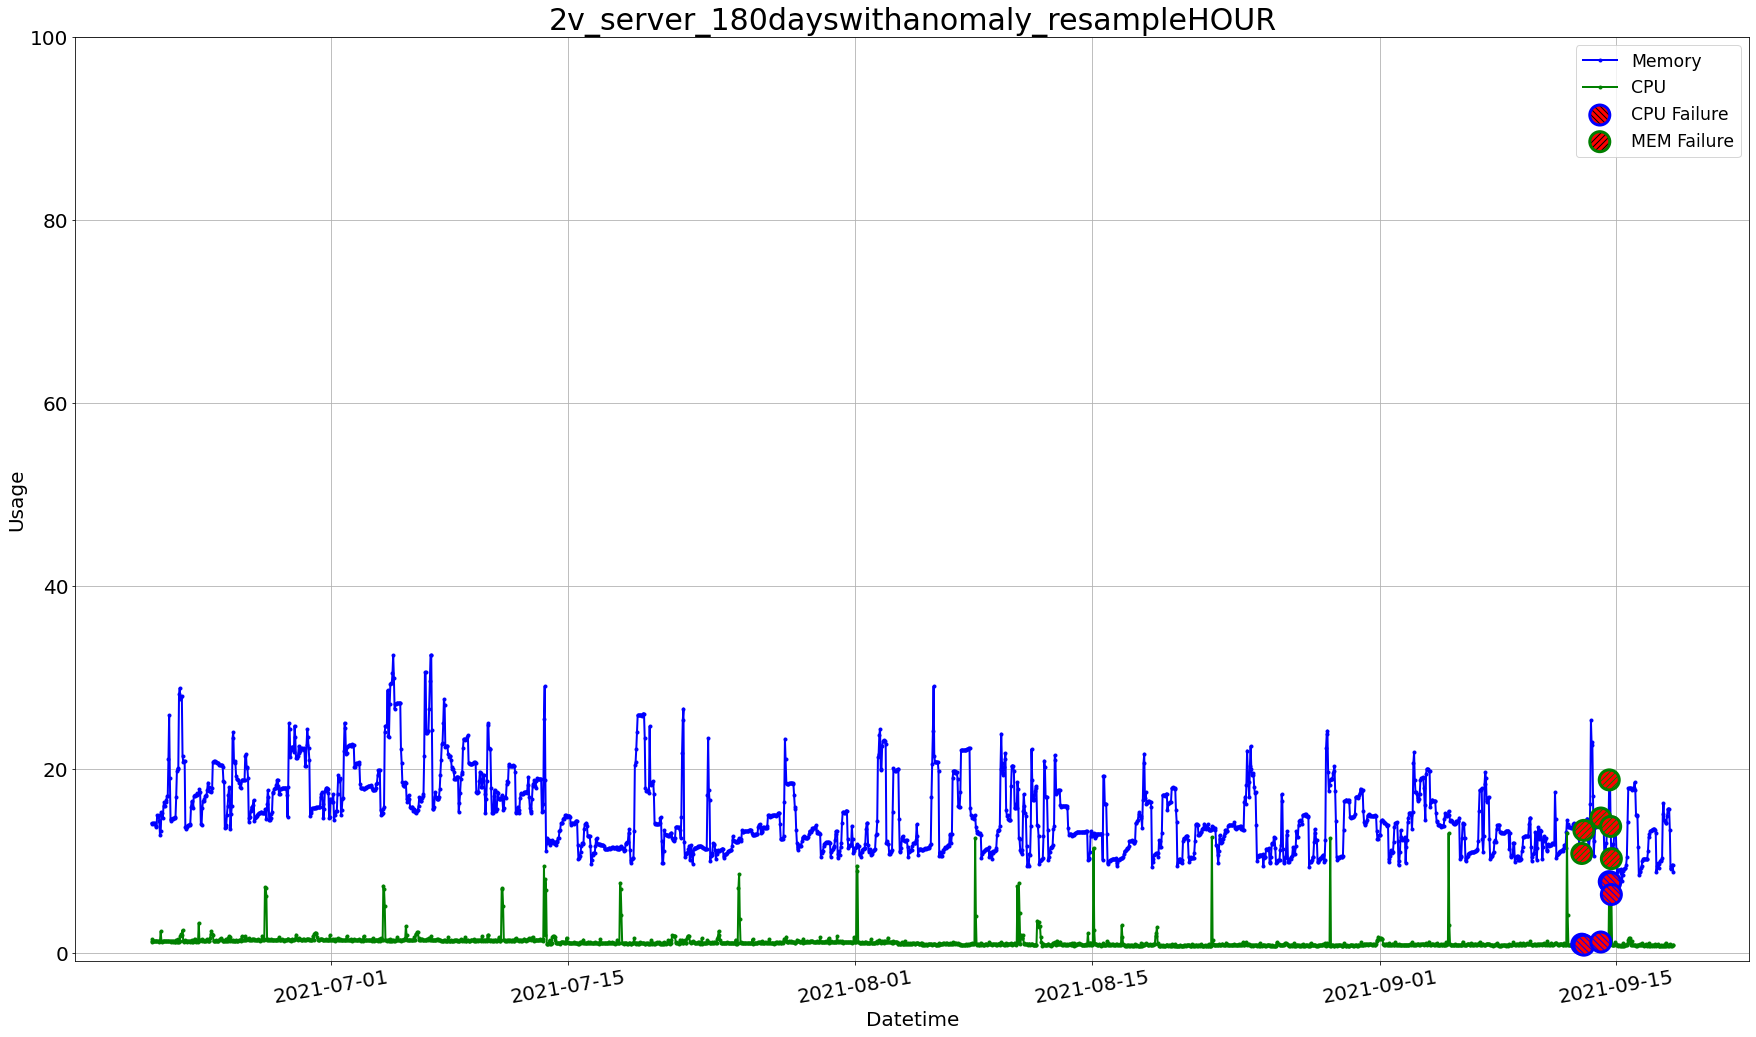

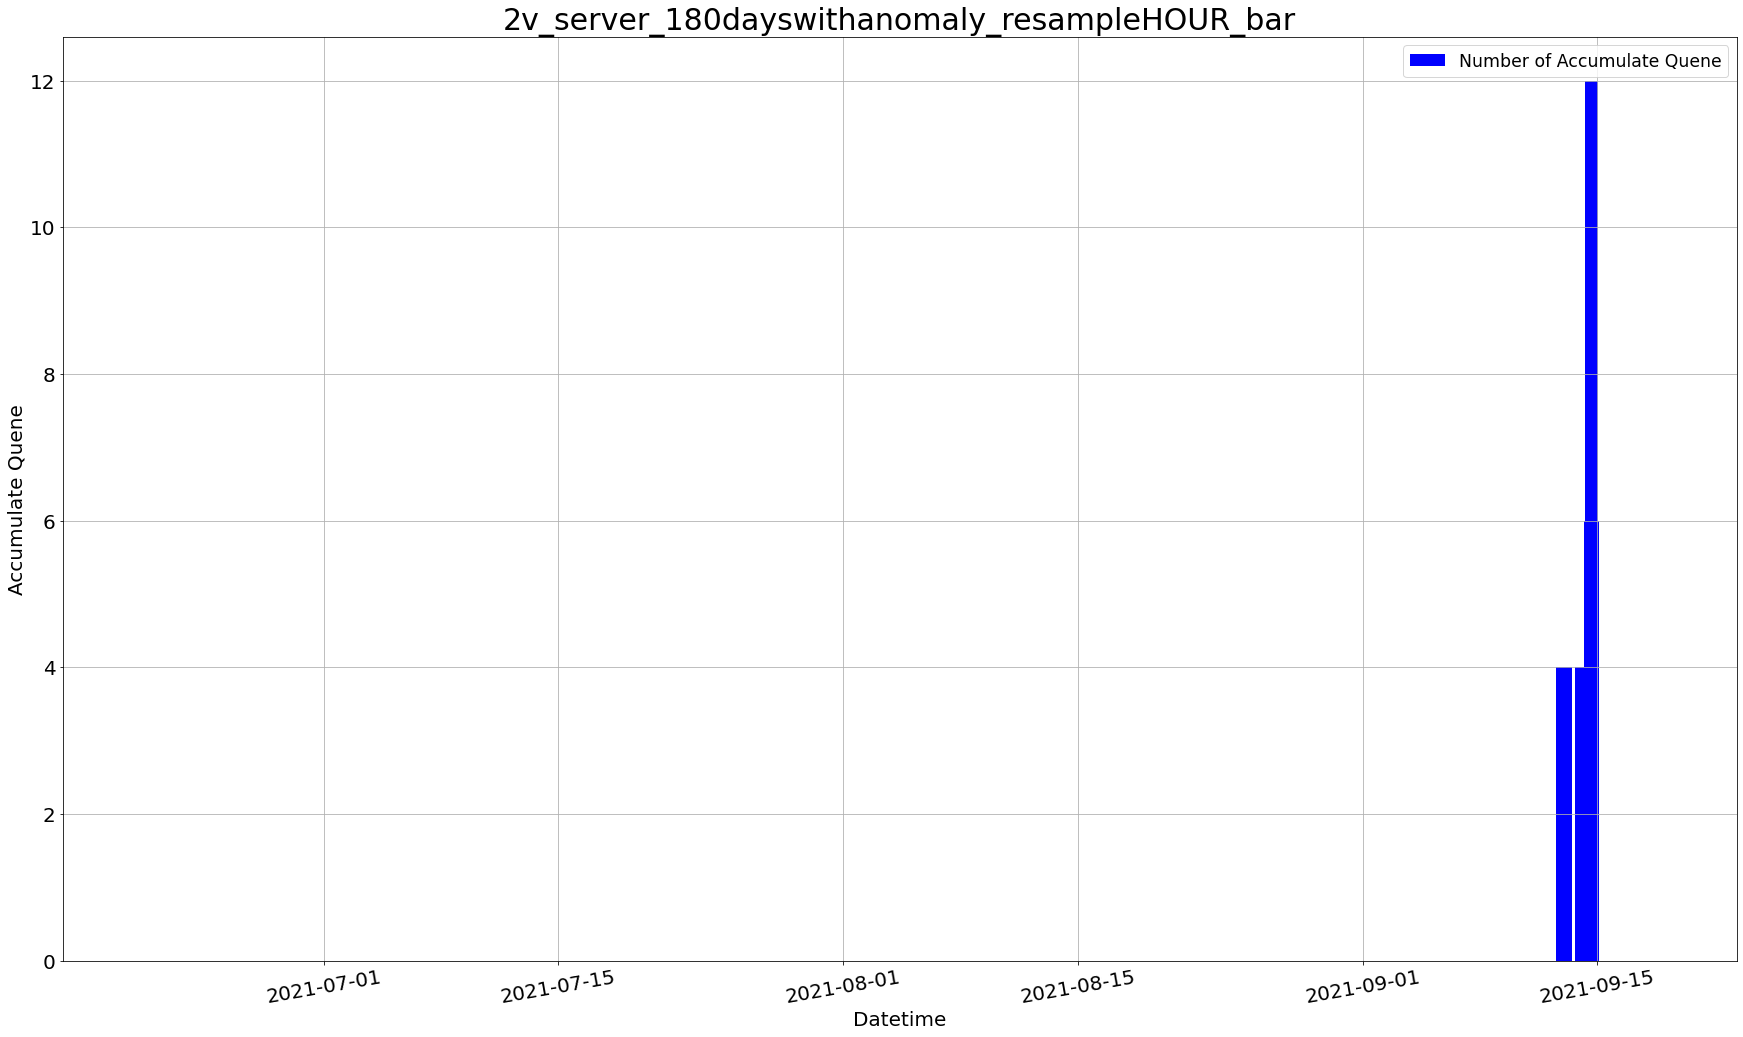

3v
host     0
name     0
value    0
dtype: int64
(90426, 5)


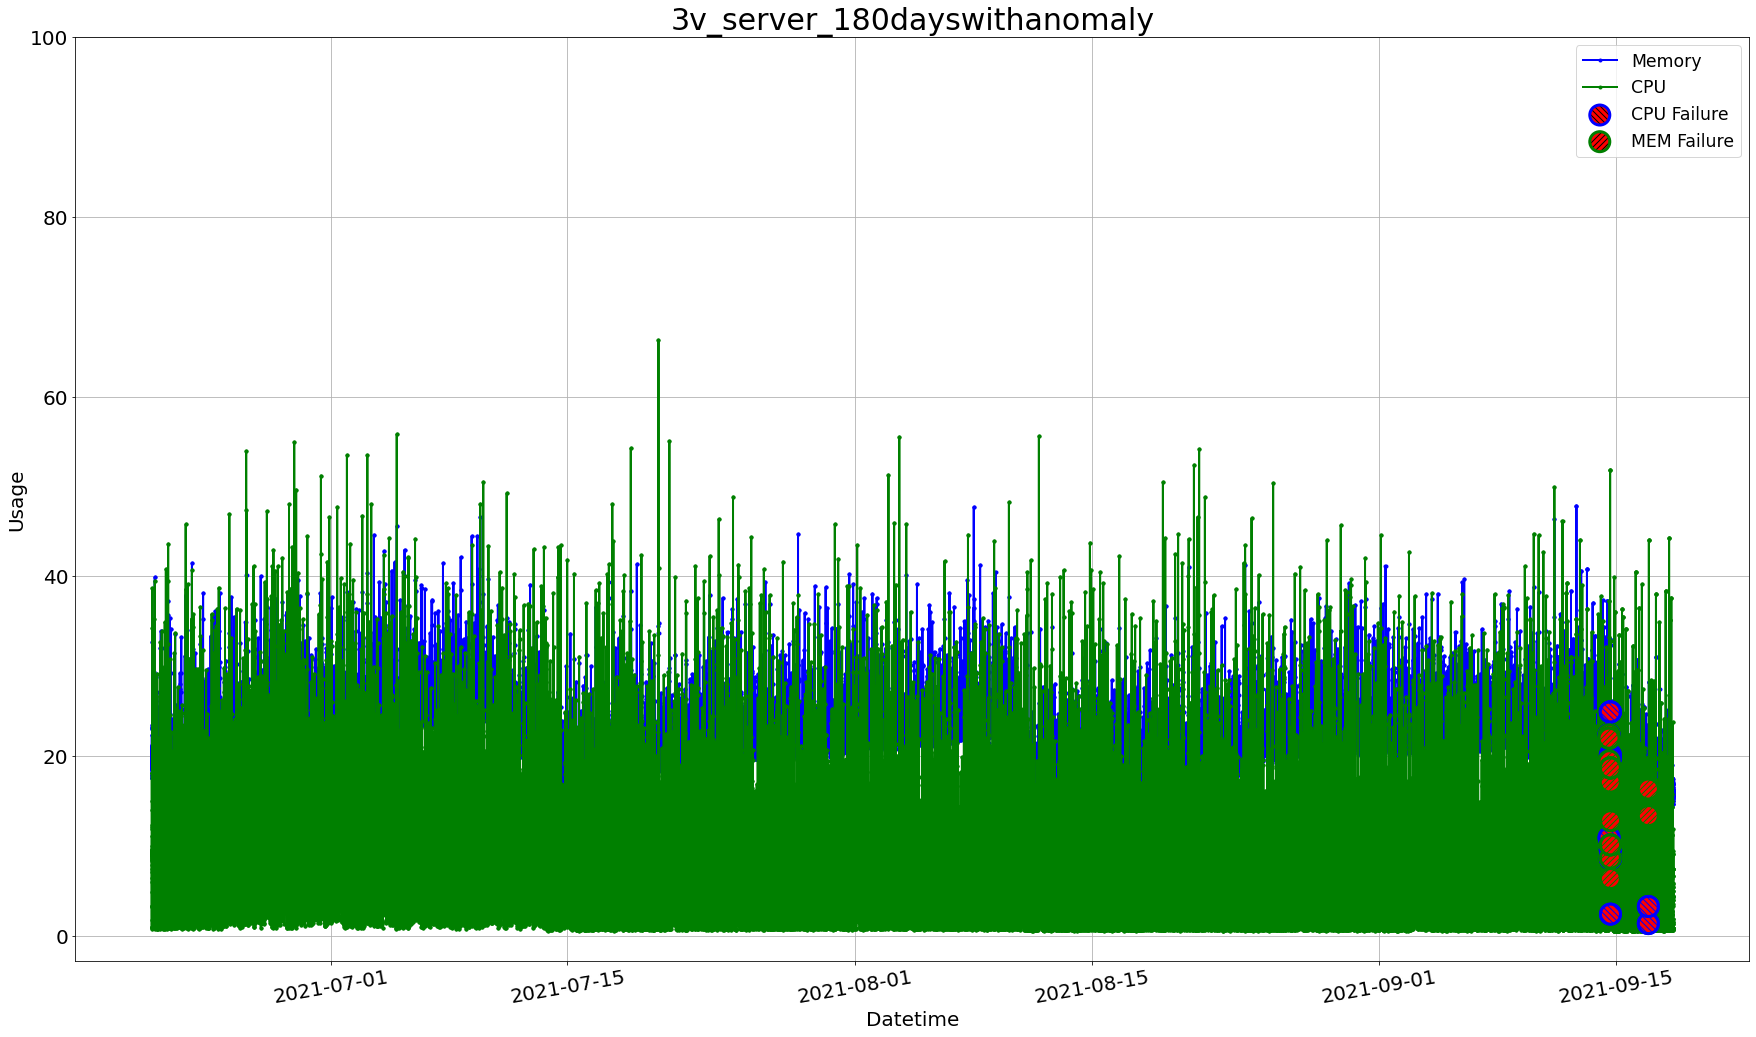

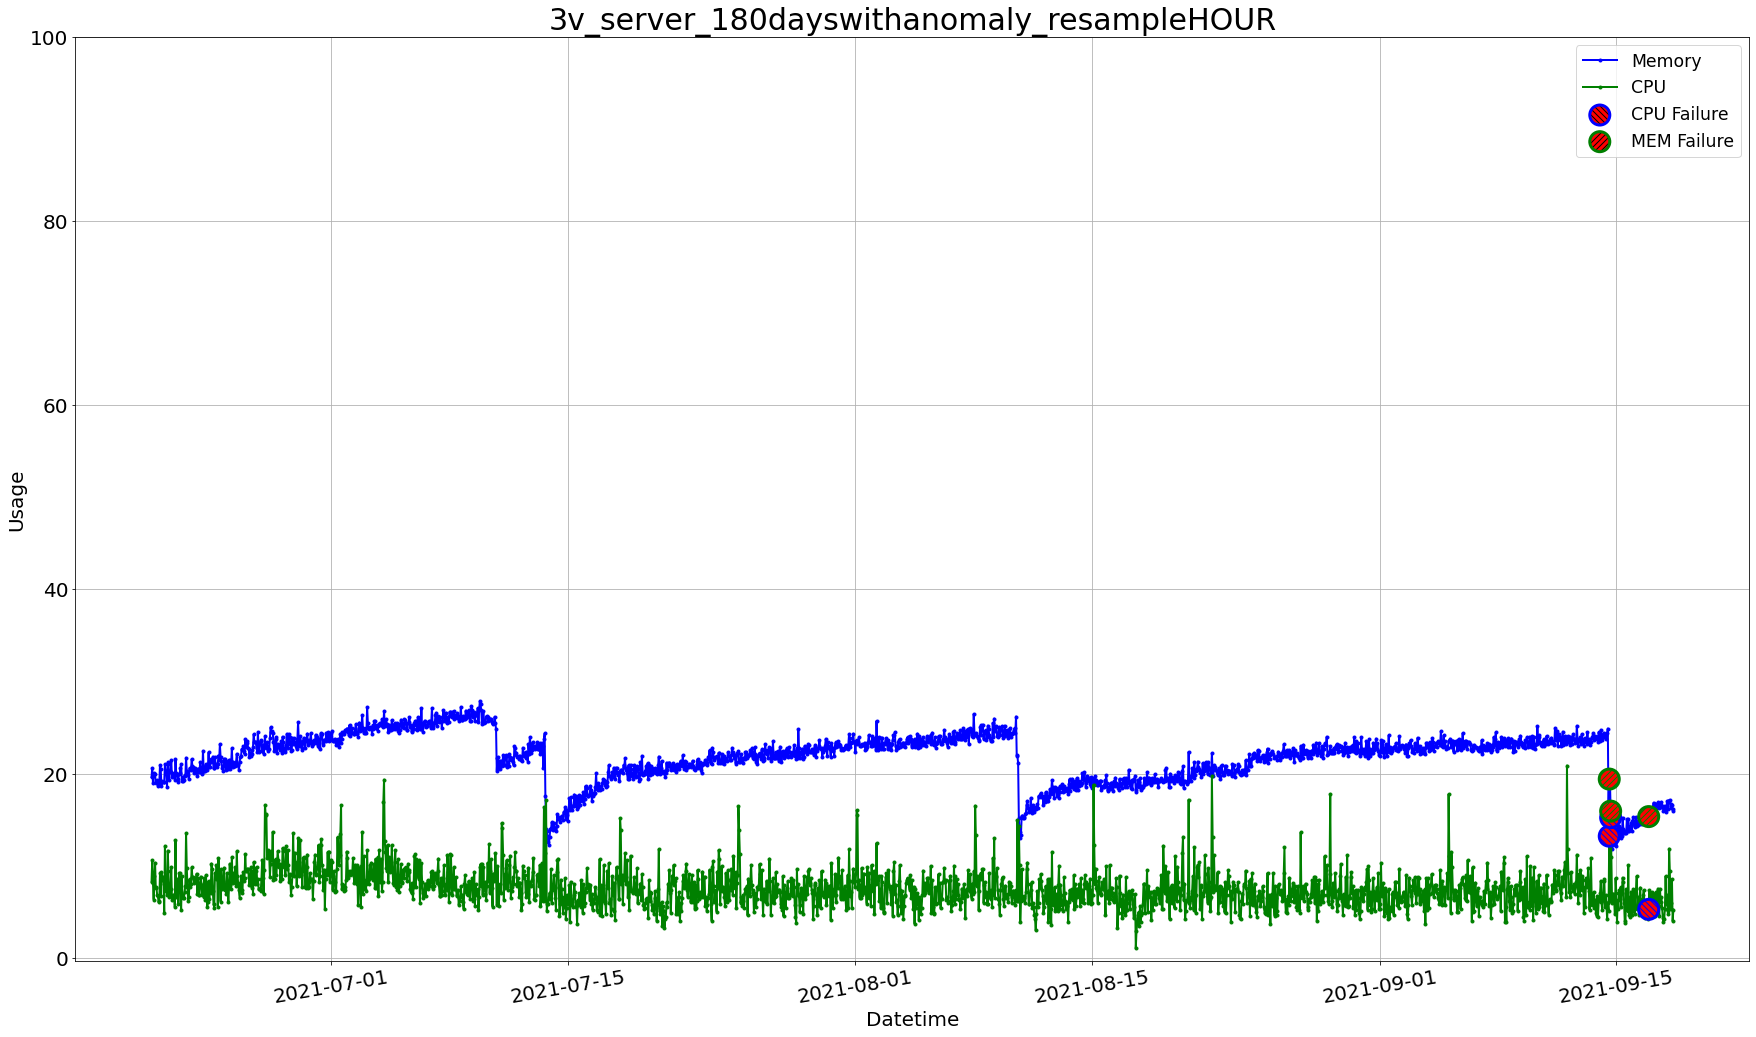

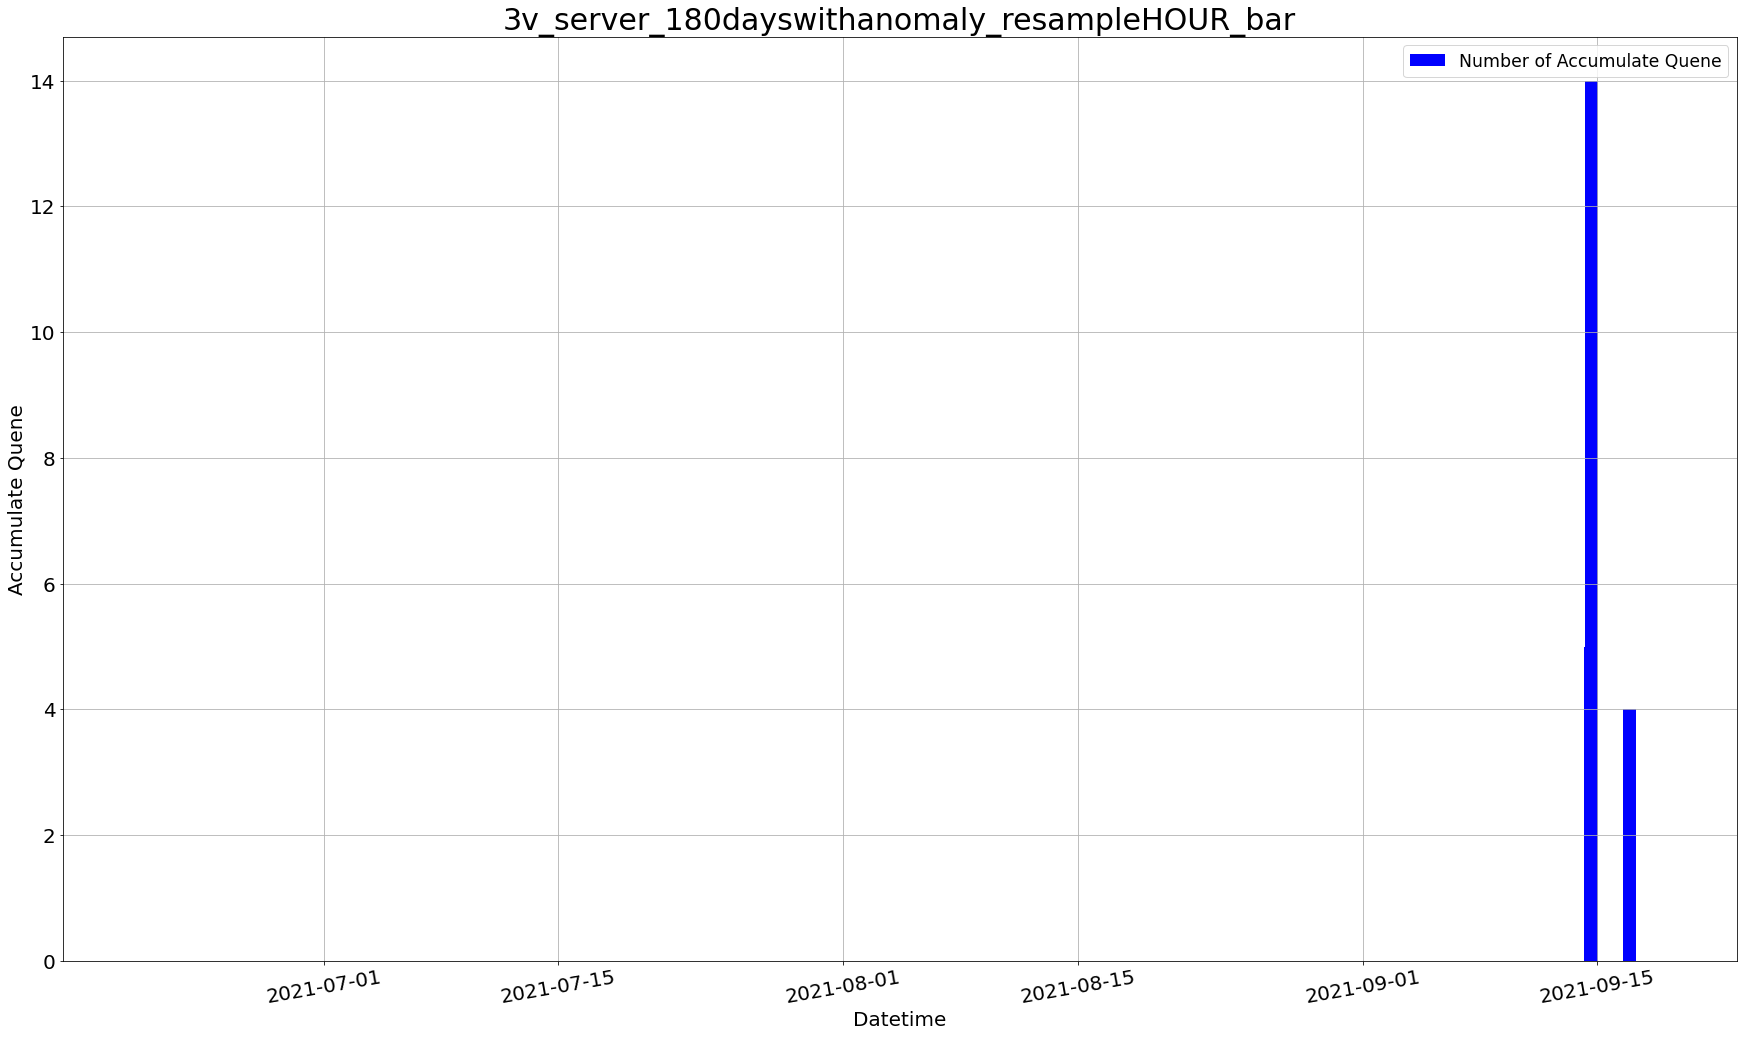

4v
host     0
name     0
value    0
dtype: int64
(90478, 5)


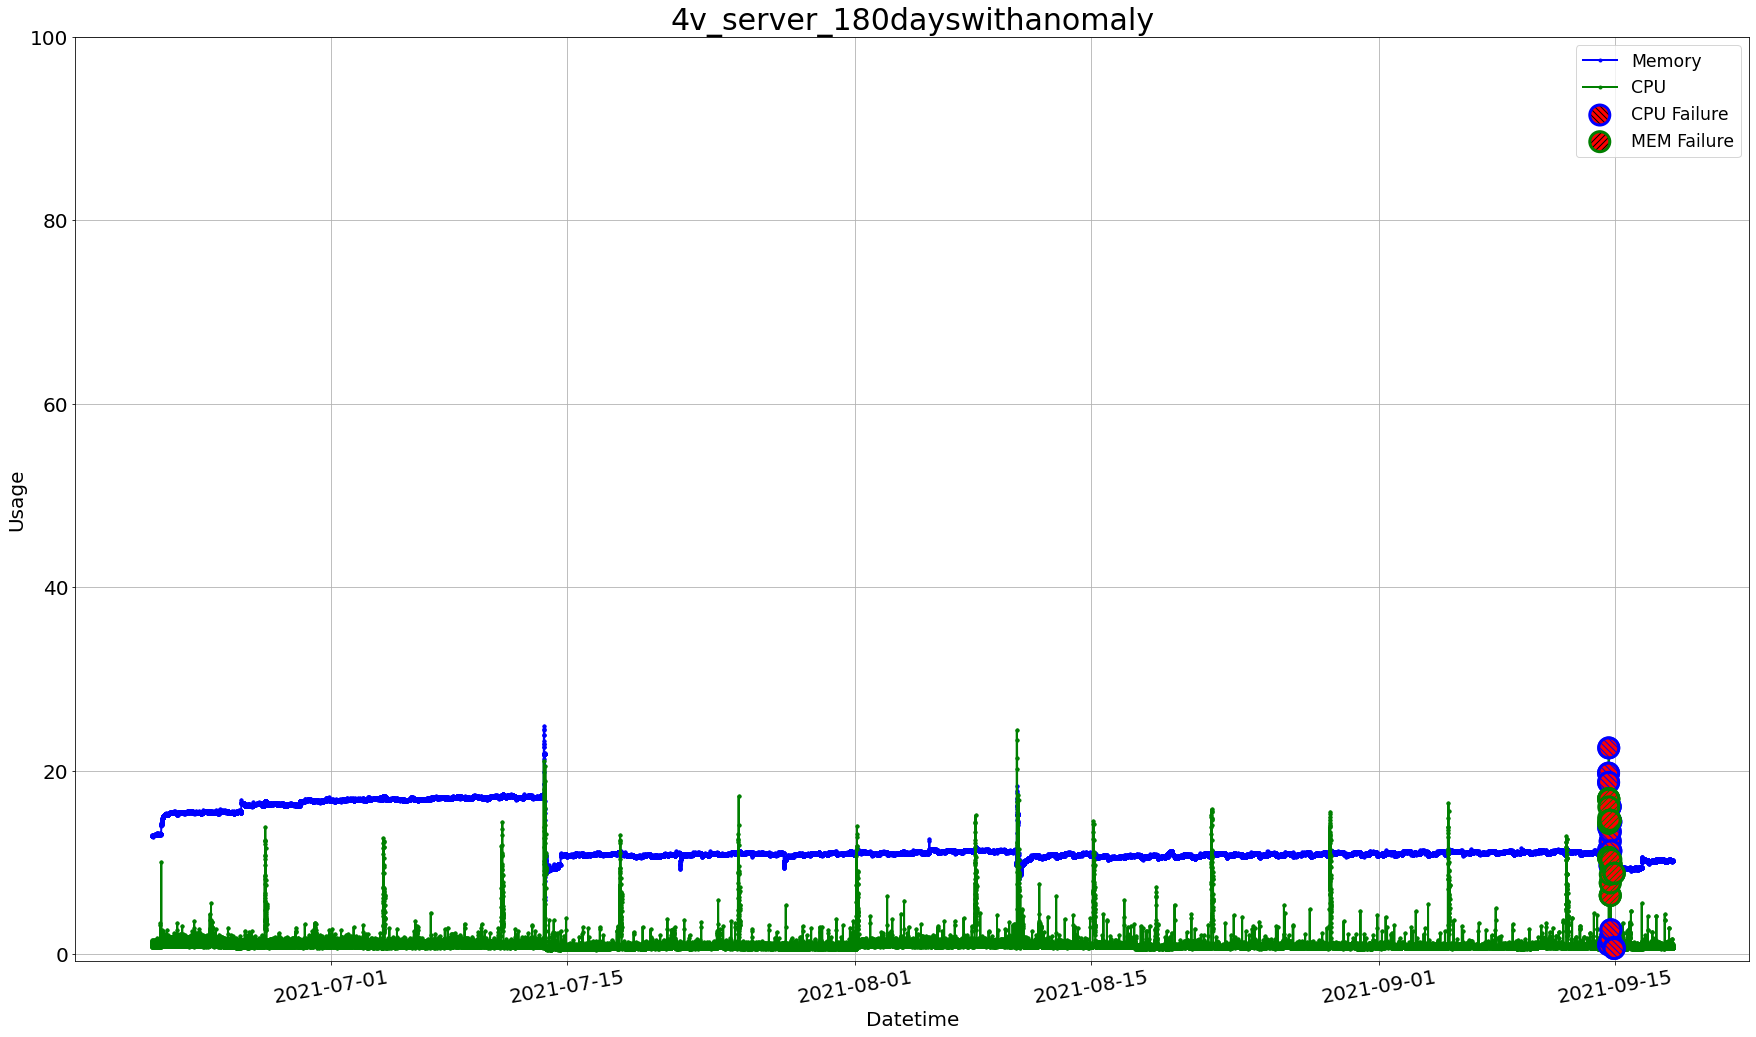

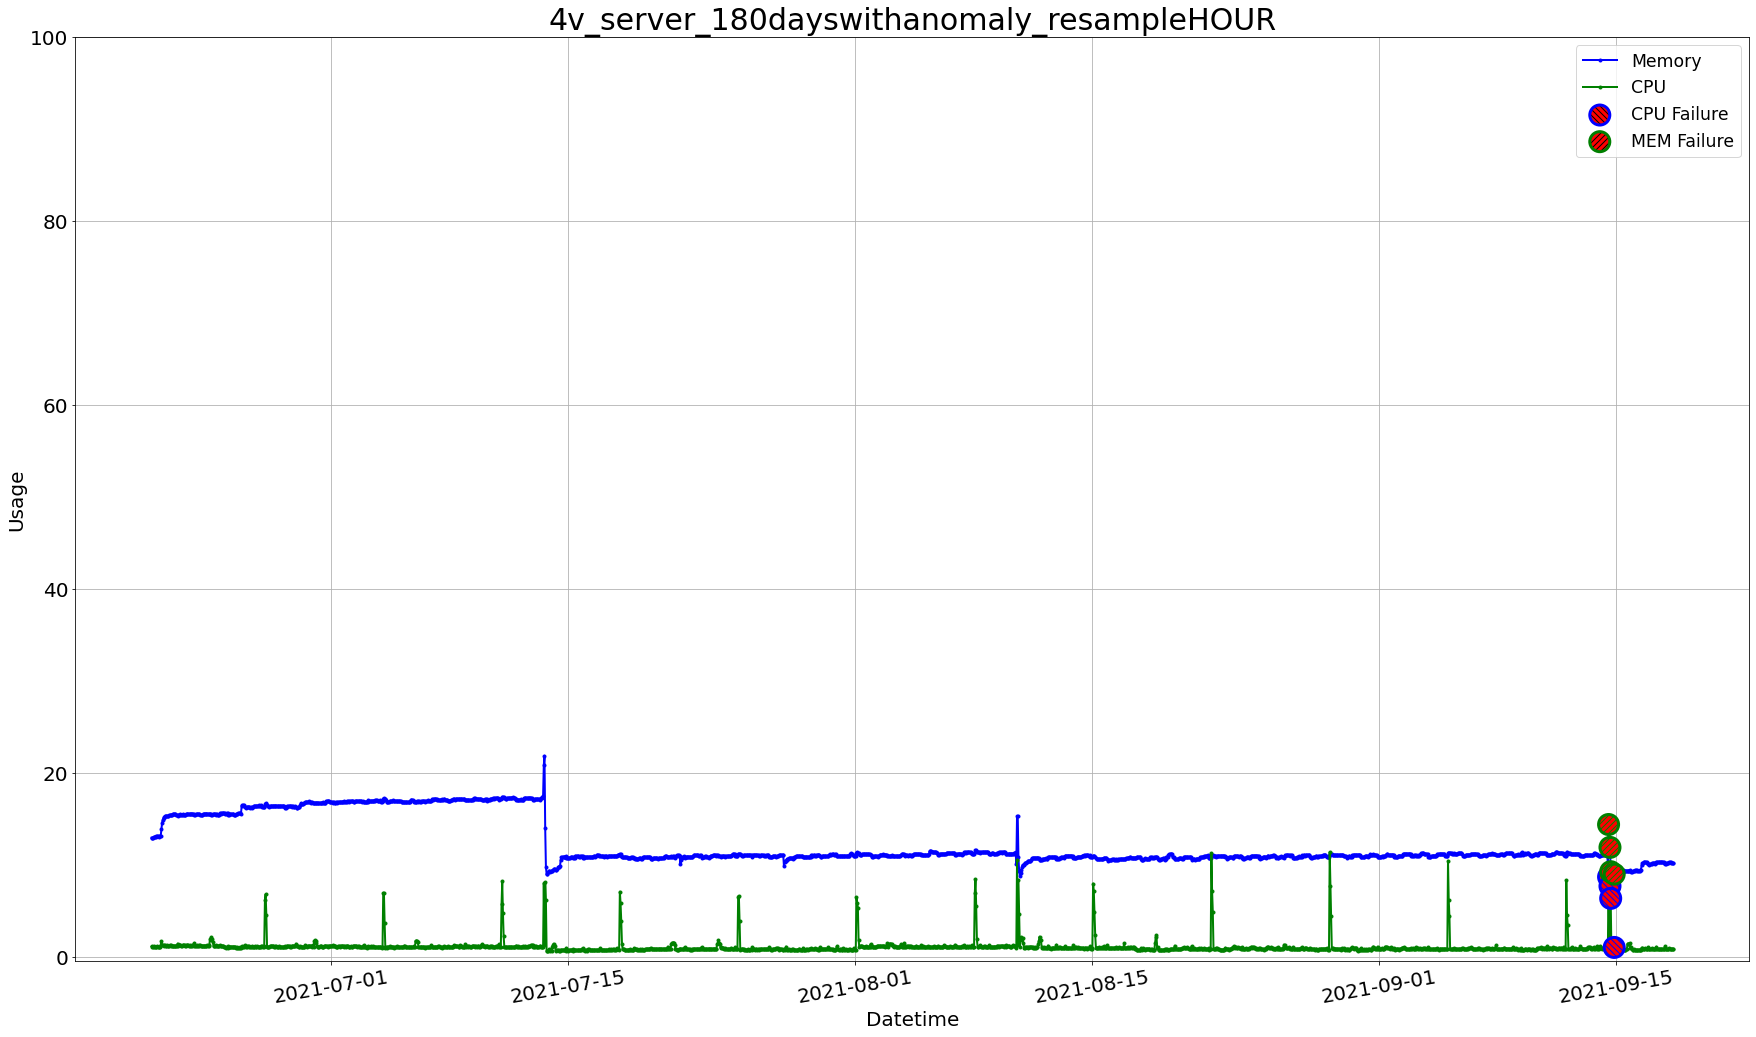

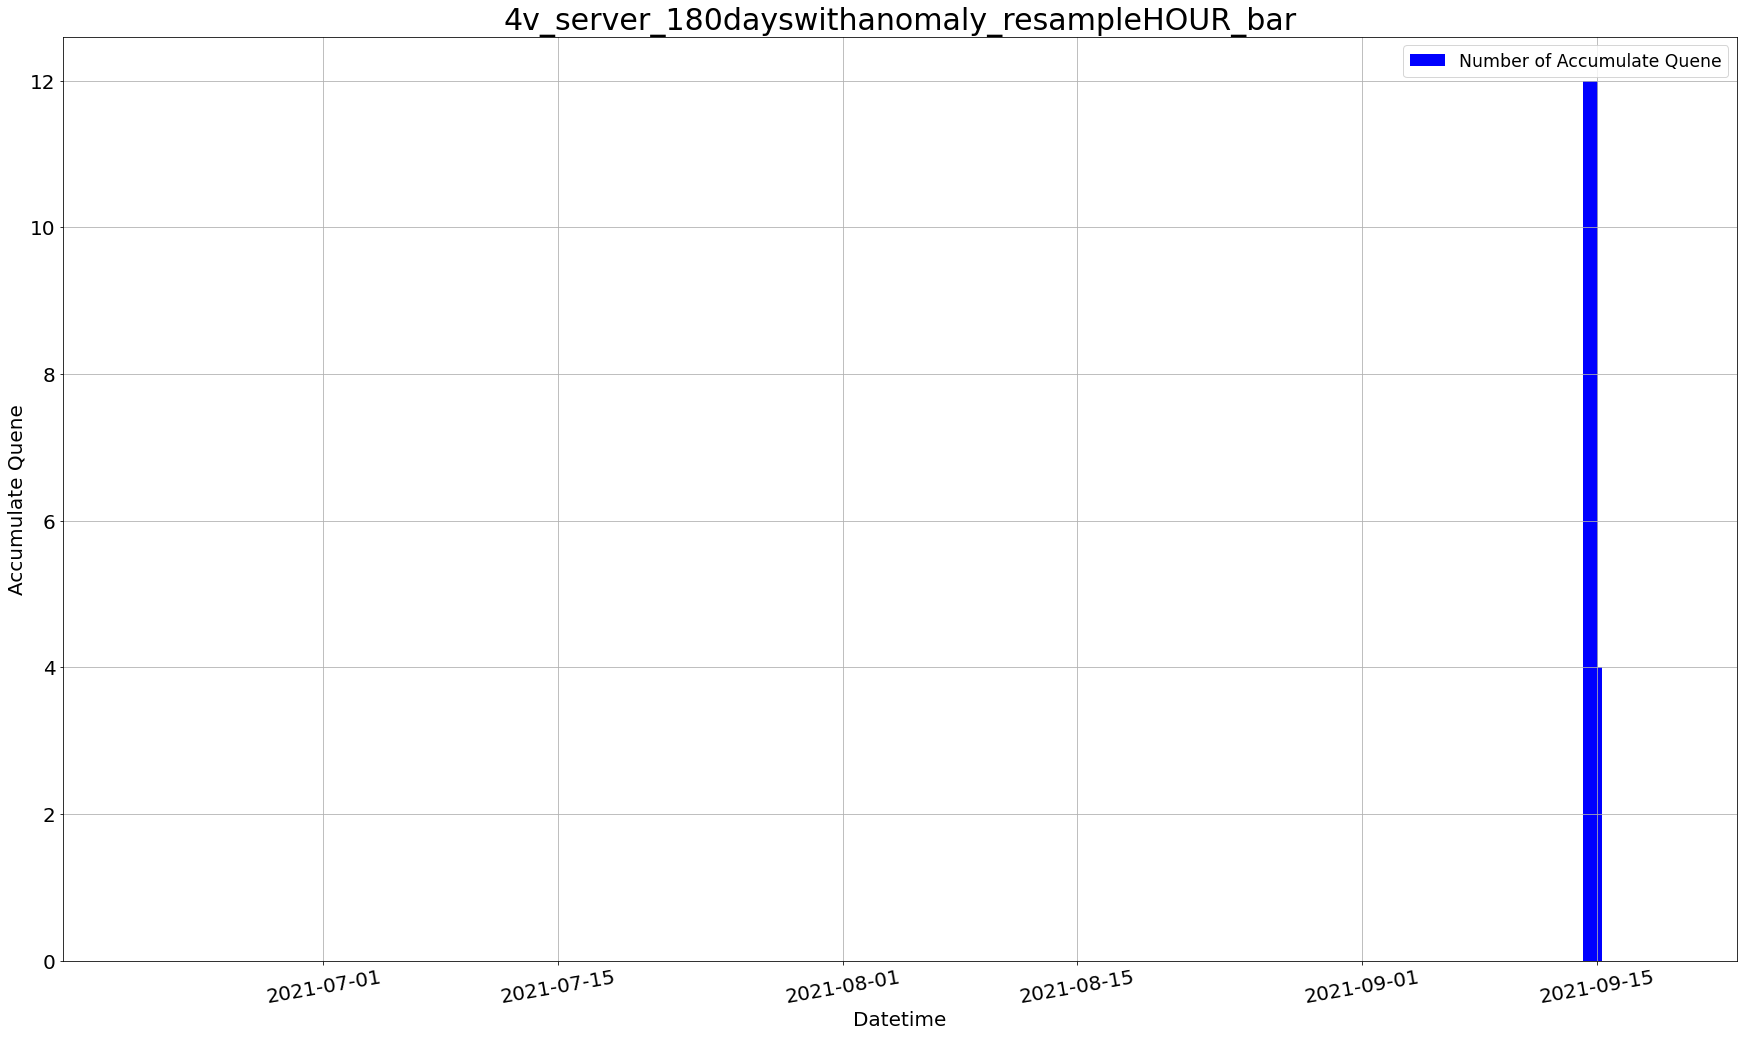

5v
host     0
name     0
value    0
dtype: int64
(90089, 5)


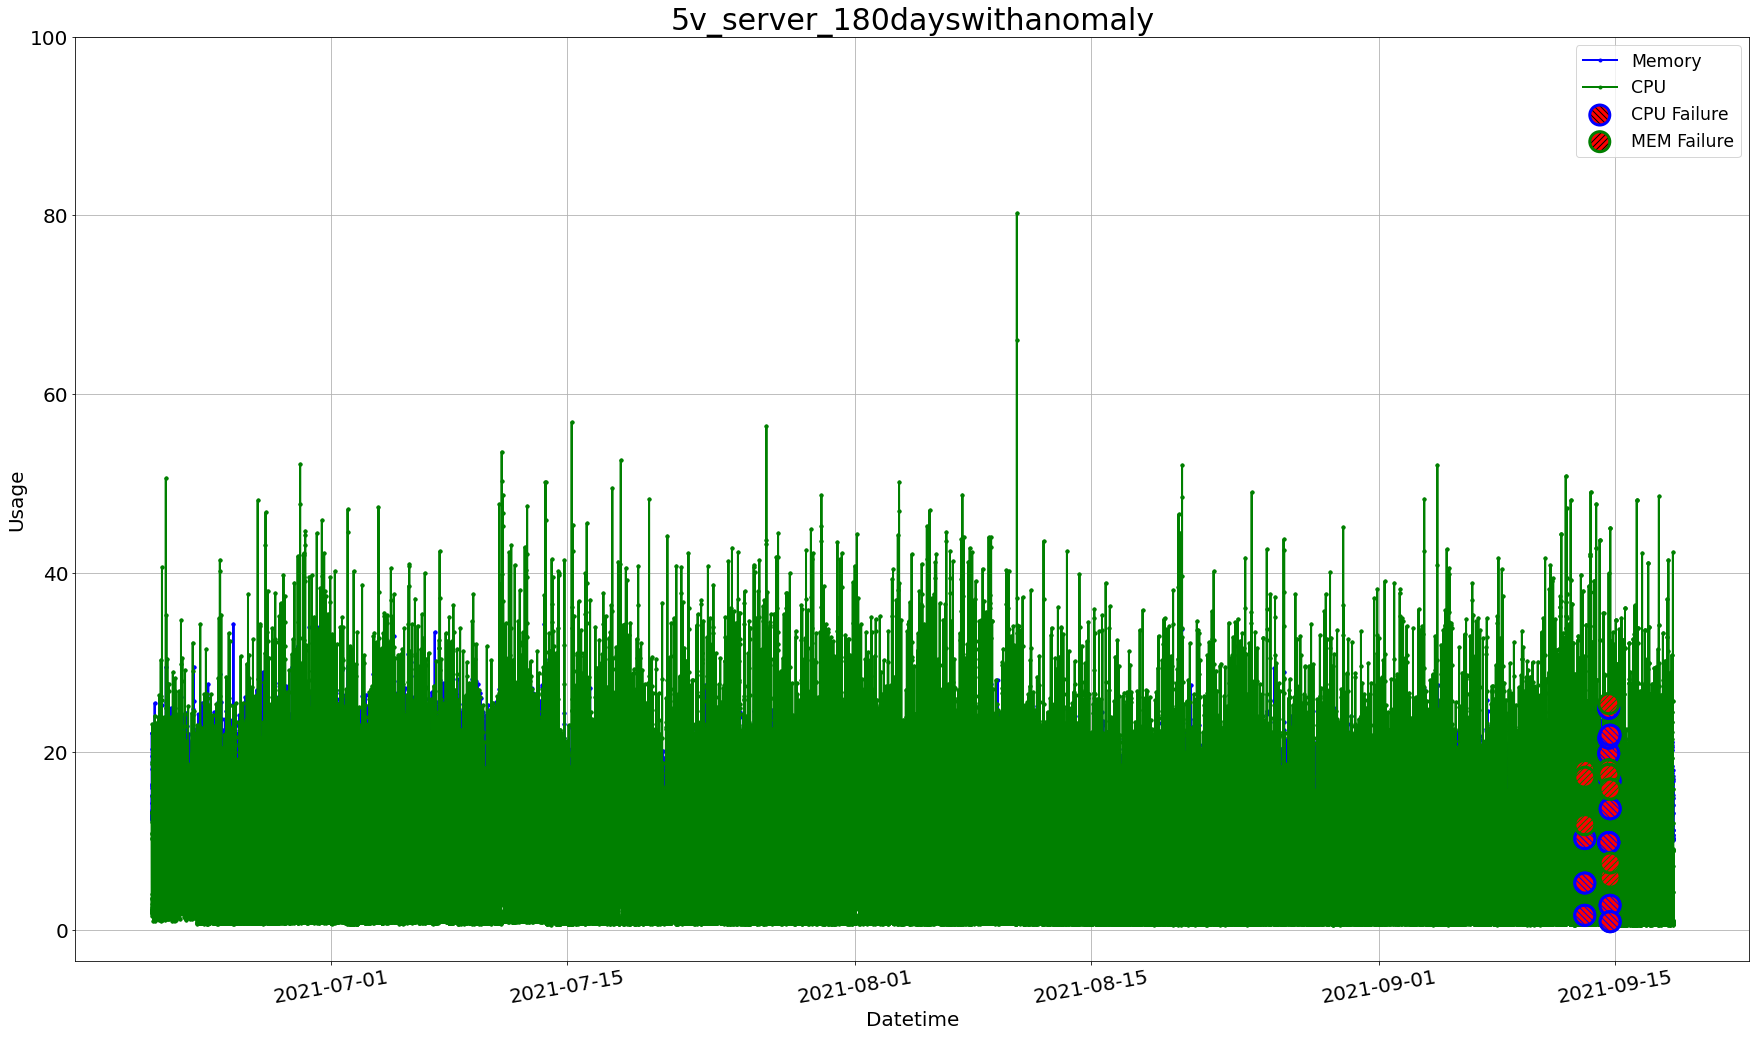

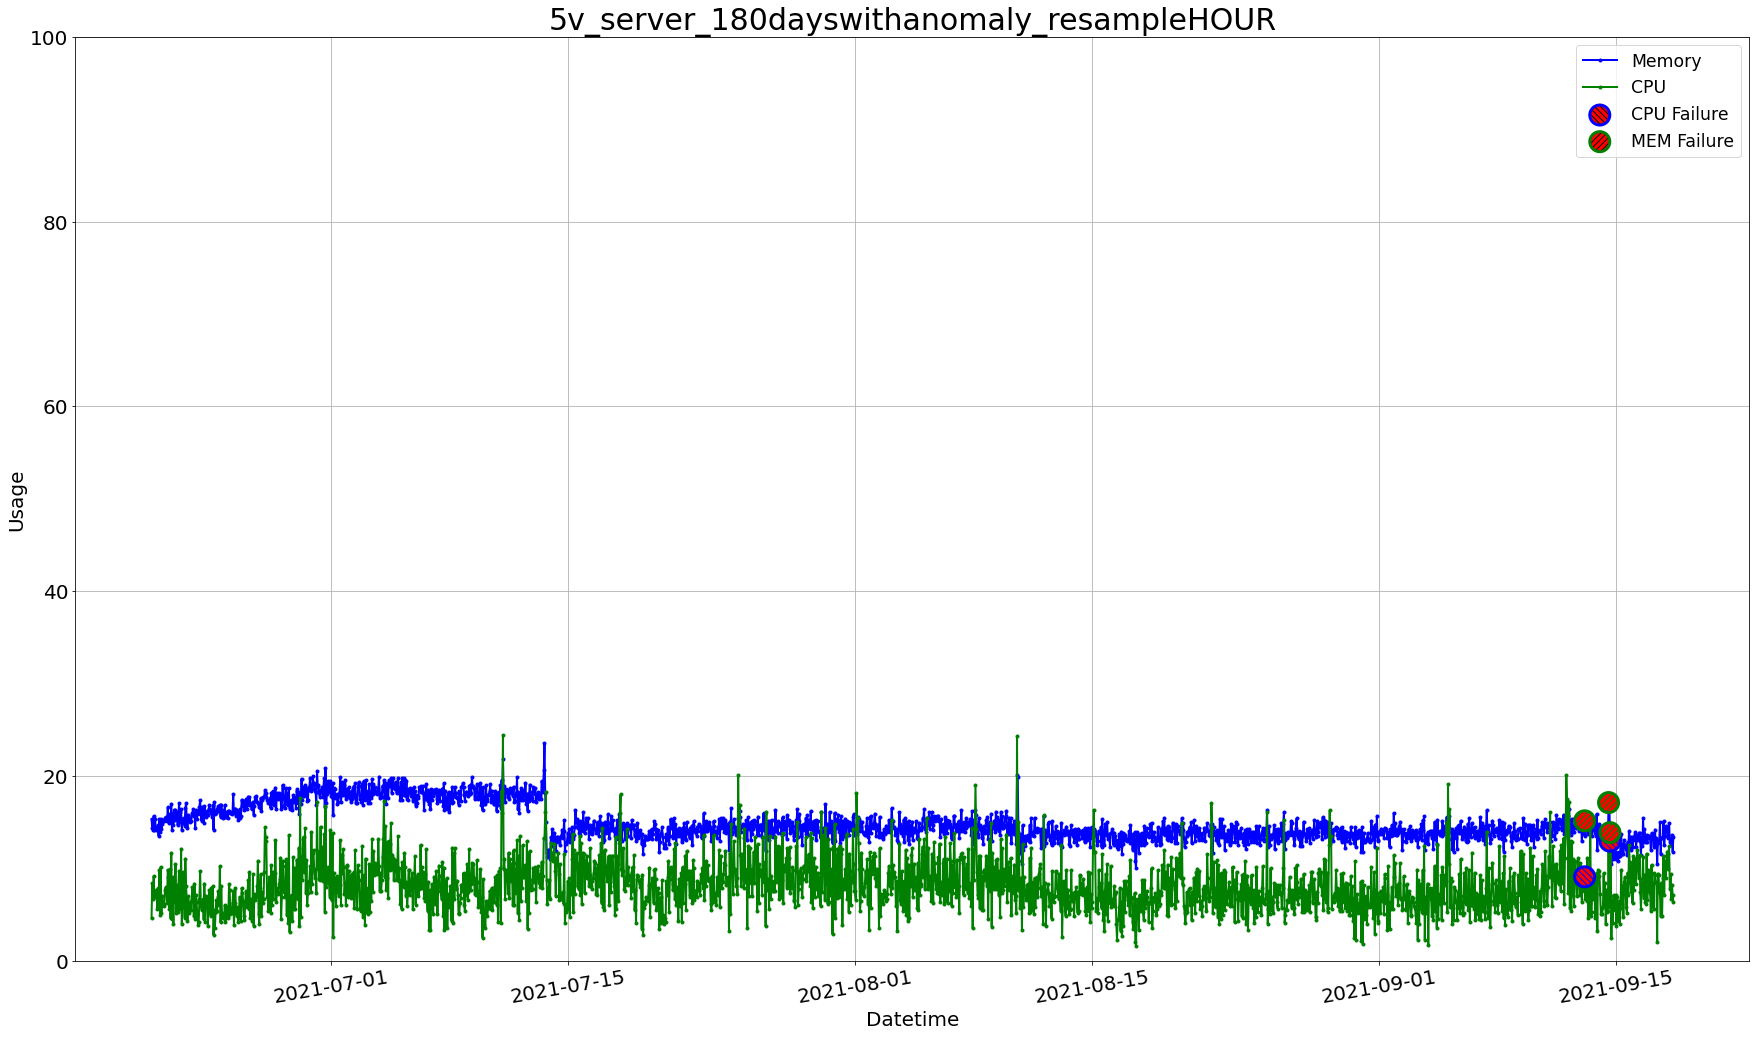

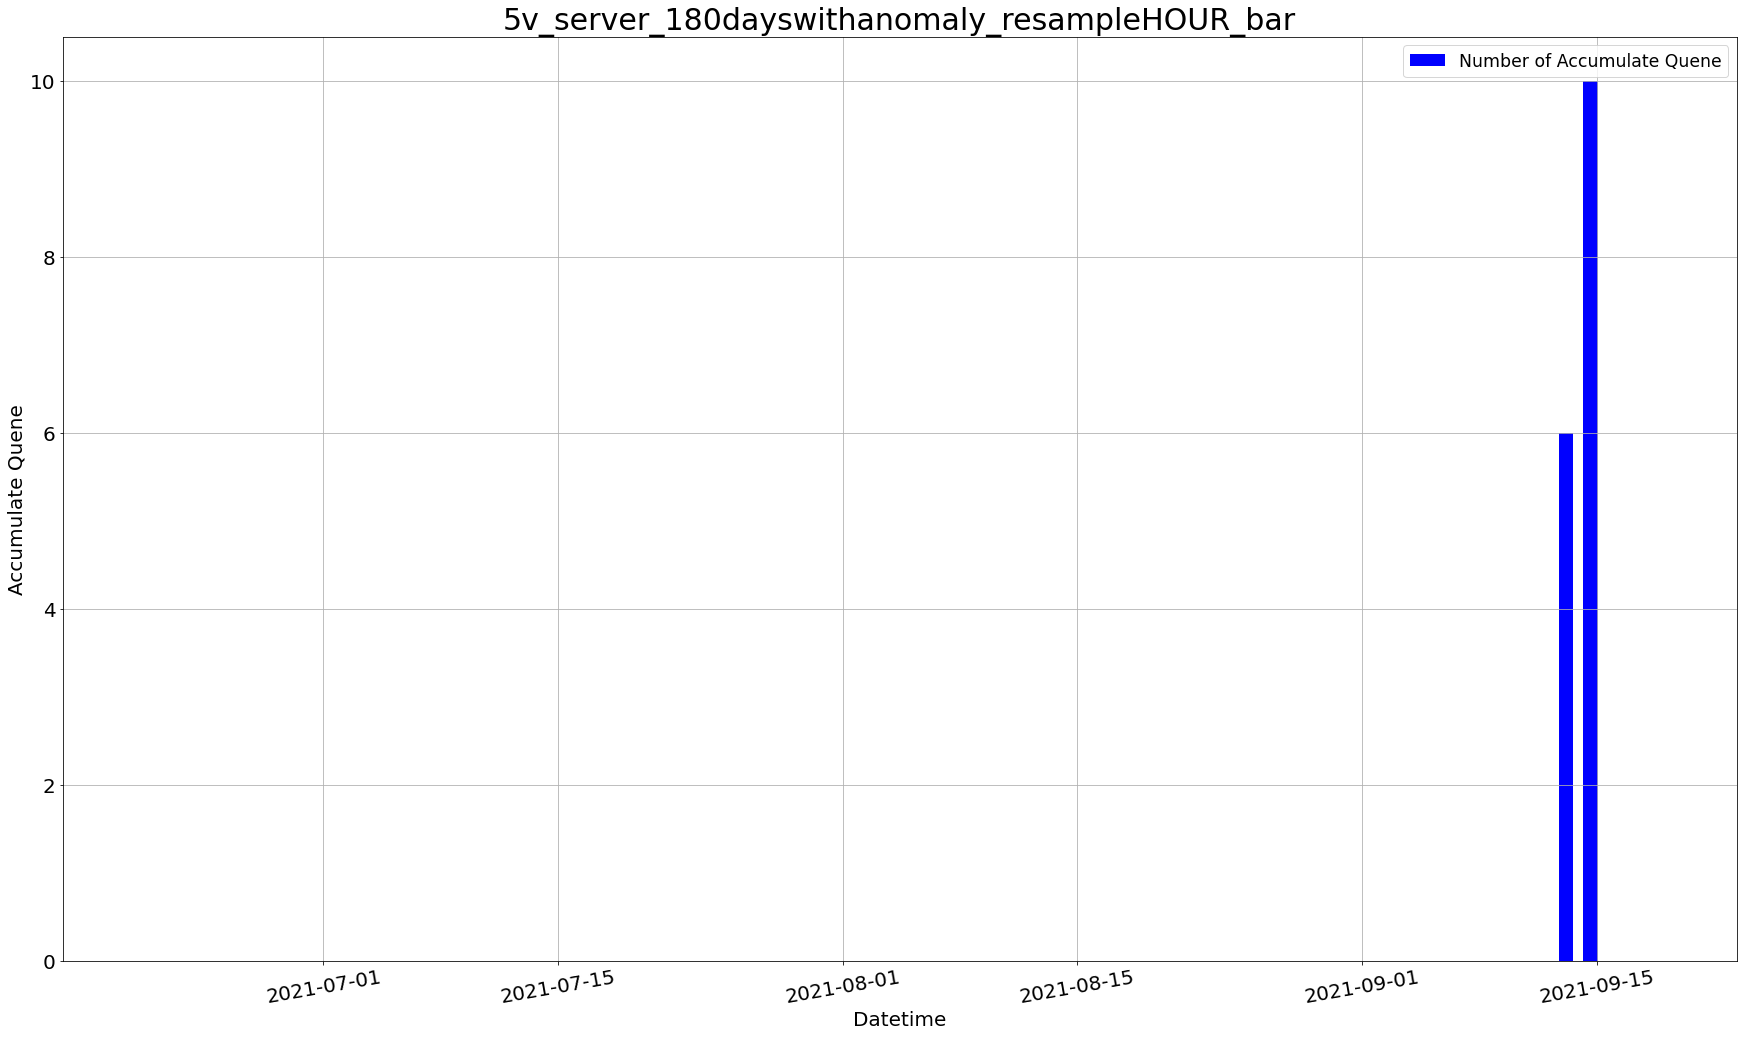

6v
host     0
name     0
value    0
dtype: int64
(89624, 5)


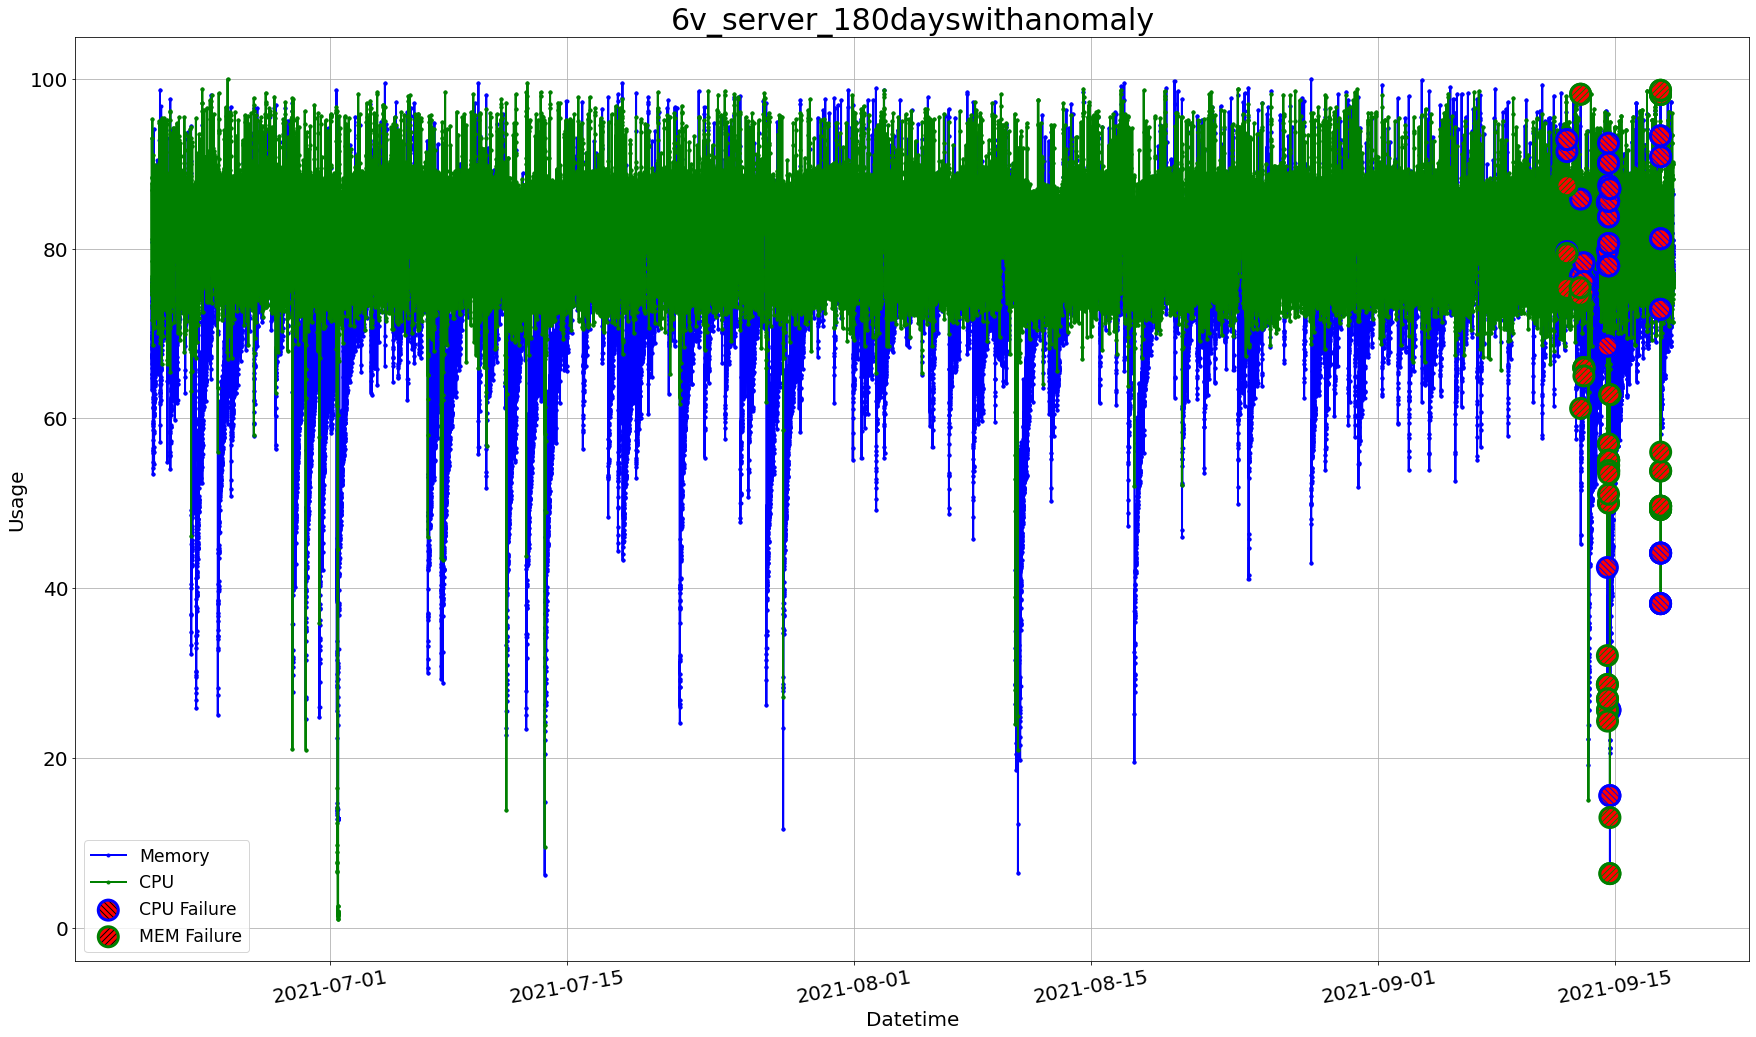

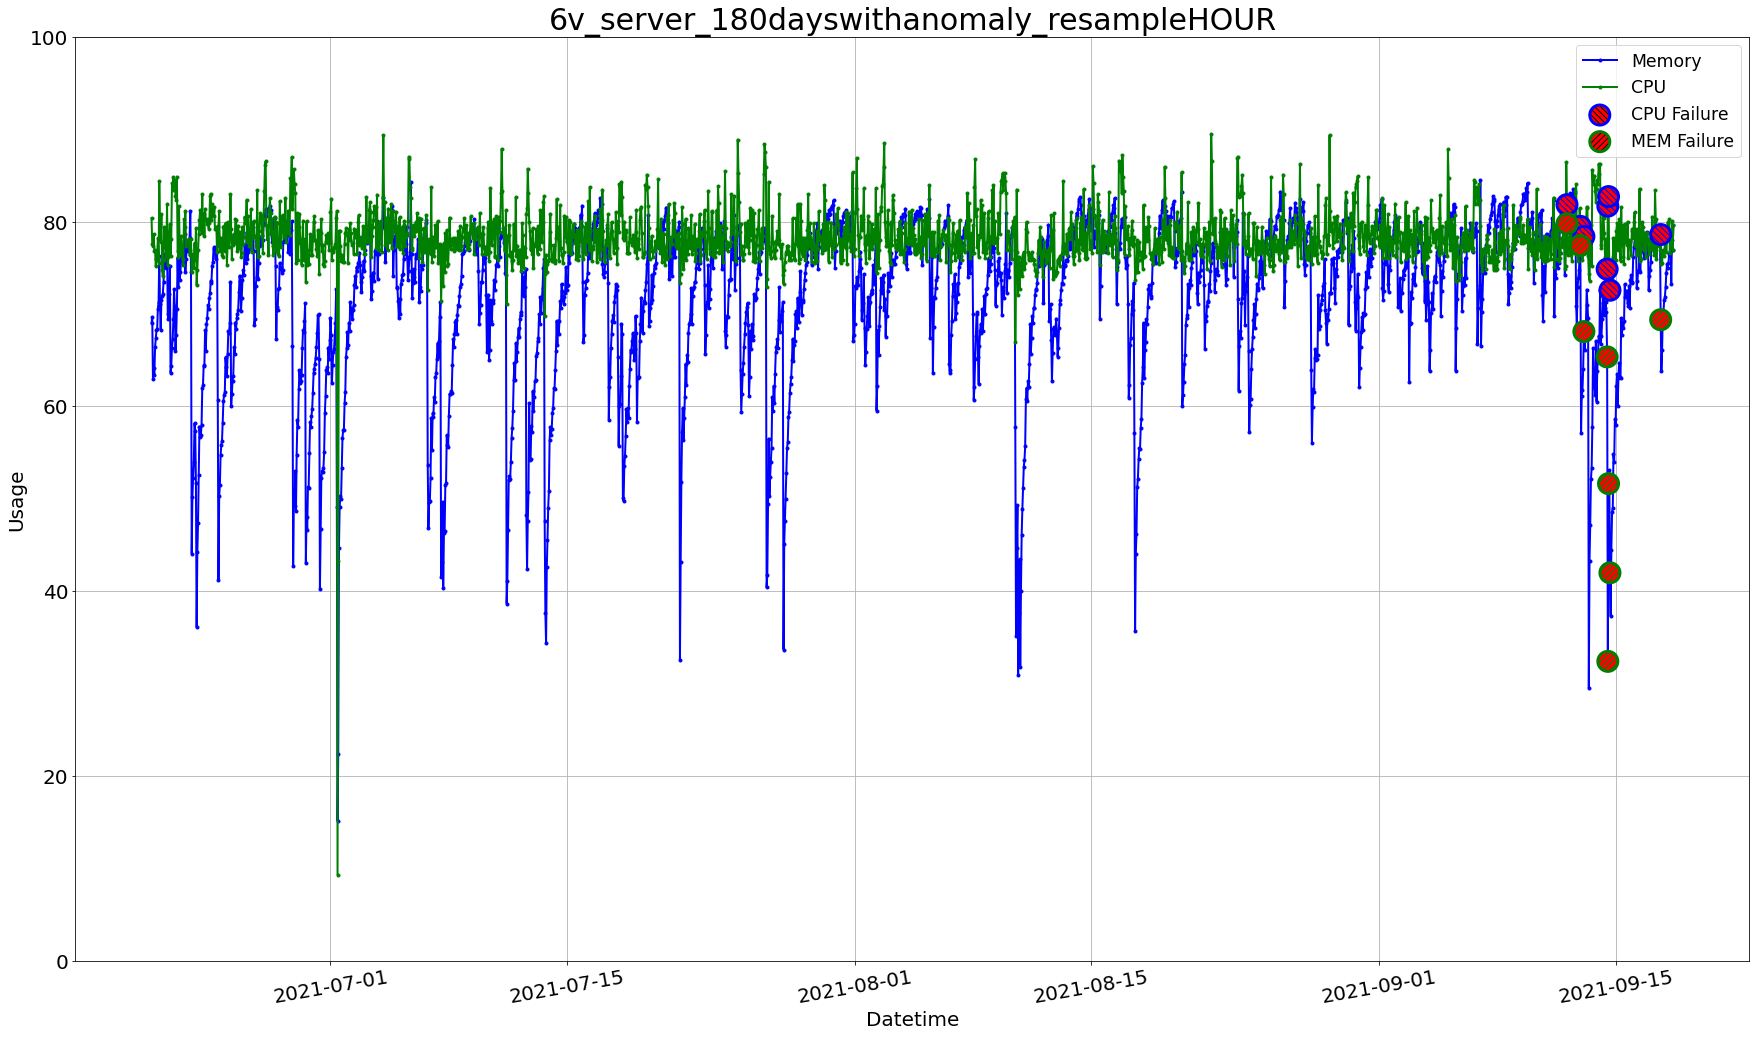

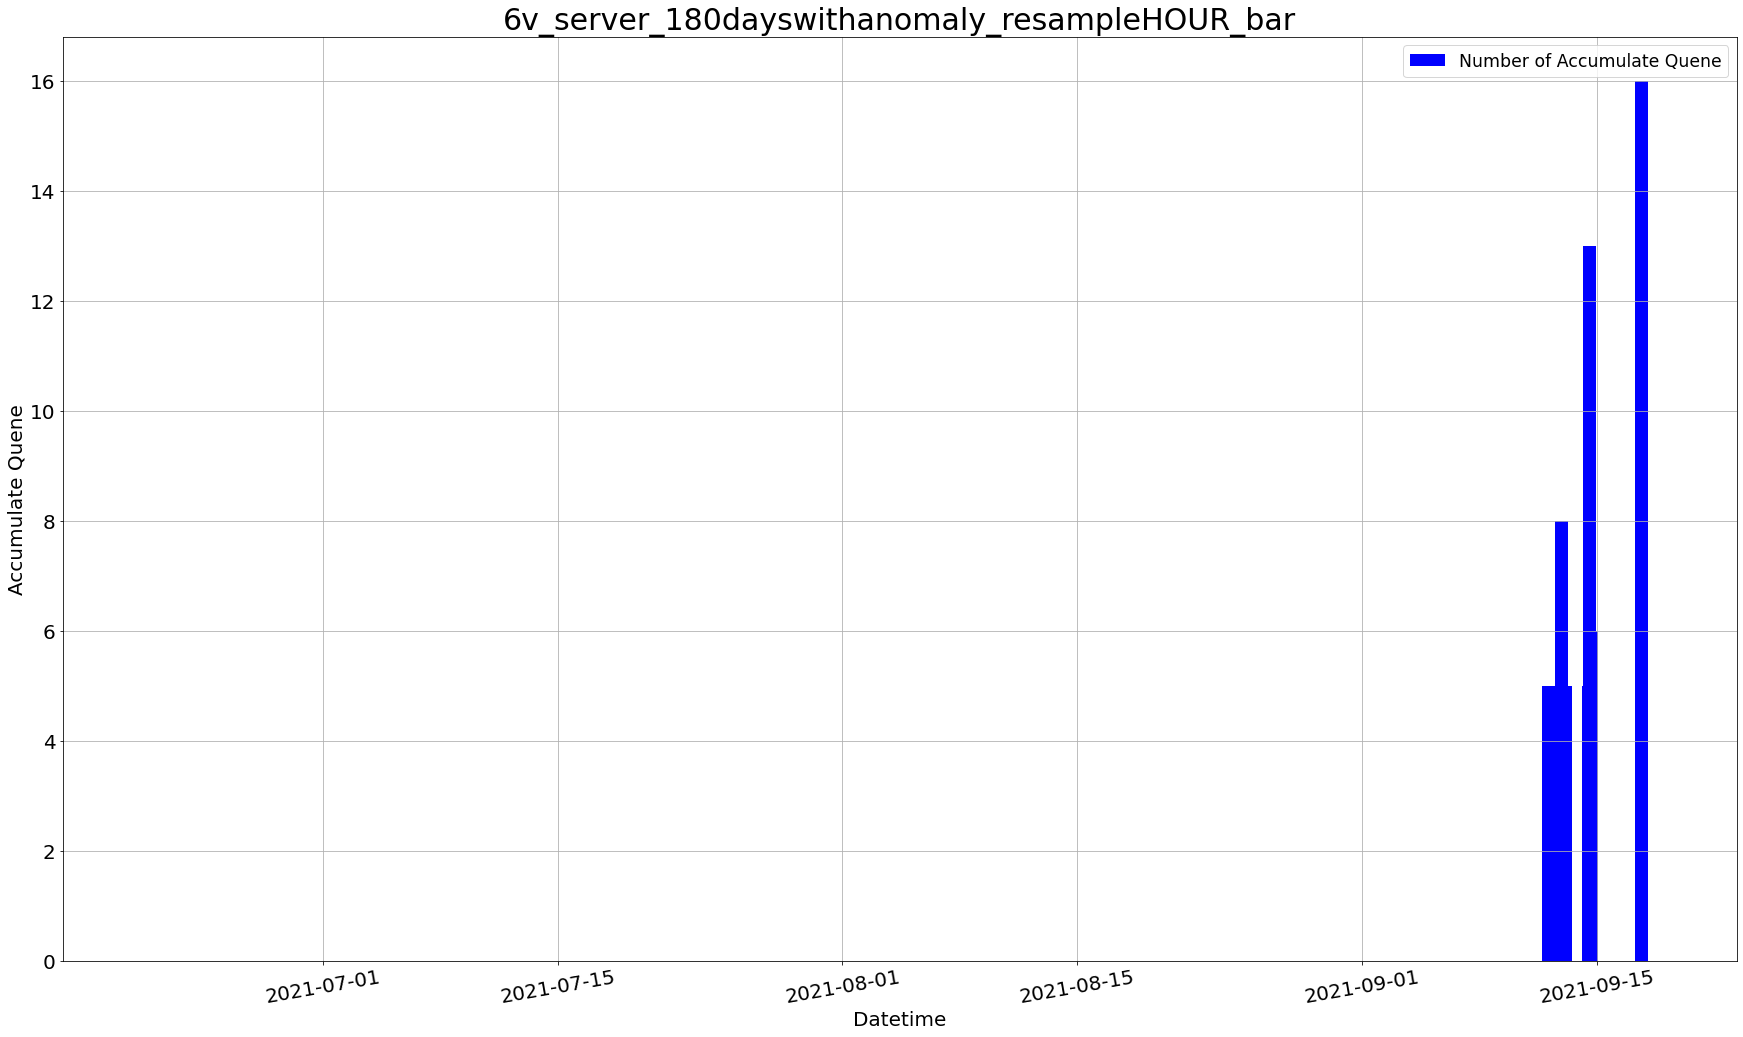

In [17]:
from IPython.core.pylabtools import figsize
 
figsize(30, 17) 
for csv in glob.glob(os.path.join(root_path,"OPTIdata","*_180days.csv")):
    
    server_name = csv.split("\\")[-1].split("_")[0]
    print(server_name)
    data = read_data(csv,o_dtname="datetime",c_dtname = 'Datetime')
    
    #get Specified name columns
    QoC_df = data[data["name"]=="Disk (0 C:) - Current Disk Queue Length"]
    QoD_df = data[data["name"]=="Disk (1 D:) - Current Disk Queue Length"]
    MEMUSG_df = data[data["name"]=="Memory used  (%)"]
    CPUUSG_df = data[data["name"]=="CPU utilization (%)"]
    
    #get last time
    #merge_time = str(QoC_df.index[-1])
    
    #select concat column
    select_col_list = [MEMUSG_df.loc[:,["value"]],
                   CPUUSG_df.loc[:,["value"]],
                   QoC_df.loc[:,["value"]],
                   QoD_df.loc[:,["value"]]]

    new_df = pd.concat(select_col_list,axis=1)
    new_df["Memory used  (%)"] = new_df.iloc[:,0]
    new_df["CPU utilization (%)"] = new_df.iloc[:,1]
    new_df["Disk (0 C:) - Current Disk Queue Length"] = new_df.iloc[:,2]
    new_df["Disk (1 D:) - Current Disk Queue Length"] = new_df.iloc[:,3]
    new_df = new_df.drop(columns="value")
    new_df.to_csv(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_beforefill.csv".format(server_name)))
    new_df.fillna(method='ffill', inplace=True)
    new_df.fillna(method='bfill', inplace=True)
    
    new_df["C_anomaly_label"] = new_df["Disk (0 C:) - Current Disk Queue Length"].apply(lambda x: 1 if x >= 3 else 0)
    new_df["D_anomaly_label"] = new_df["Disk (1 D:) - Current Disk Queue Length"].apply(lambda x: 1 if x >= 3 else 0)
    new_df["anomaly_value"] = new_df["C_anomaly_label"]+ new_df["D_anomaly_label"]
    new_df["anomaly_label"] = new_df["anomaly_value"].apply(lambda x: 1 if x >= 1 else 0)
    new_df = new_df.drop(columns=["C_anomaly_label","D_anomaly_label","anomaly_value"])
    new_df.to_csv(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly.csv".format(server_name)))
    print(new_df.shape)
    plt.plot(new_df.index.values,new_df.iloc[:,0],label="Memory",color="blue",zorder=10,marker='.',linewidth=2)
    plt.plot(new_df.index.values,new_df.iloc[:,1],label="CPU",color="green",zorder=20,marker='.',linewidth=2)
    plt.scatter(new_df[new_df["anomaly_label"]==1].index.values,new_df[new_df["anomaly_label"]==1]["CPU utilization (%)"].values,
                s=400,
                color="red",
                label="CPU Failure",
                zorder=30,
                edgecolors="blue",
                linewidth=3,
                hatch=r'\\\\')
    plt.scatter(new_df[new_df["anomaly_label"]==1].index.values,new_df[new_df["anomaly_label"]==1]["Memory used  (%)"].values,
                s=400,
                color="red",
                label="MEM Failure",
                zorder=30,
                edgecolors="green",
                linewidth=3,
                hatch='////')
    plt.title("{}_server_180dayswithanomaly".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Usage",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(range(0,120,20),fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly.jpg".format(server_name)))
    plt.show()
    
    
    resample_data = pd.concat([new_df.iloc[:,[0,1]].resample("h").mean(),new_df.iloc[:,[2,3,4]].resample("h").sum()],axis=1)
    resample_data["Label"] = resample_data["anomaly_label"].apply(lambda x: 1 if x >= 1 else 0)
    
    
    
    plt.plot(resample_data.index.values,resample_data.iloc[:,0],label="Memory",color="blue",zorder=10,marker='.',linewidth=2)
    plt.plot(resample_data.index.values,resample_data.iloc[:,1],label="CPU",color="green",zorder=20,marker='.',linewidth=2)
    plt.scatter(resample_data[resample_data["anomaly_label"]>1].index.values,resample_data[resample_data["anomaly_label"]>1]["CPU utilization (%)"].values,
                s=400,
                color="red",
                label="CPU Failure",
                zorder=30,
                edgecolors="blue",
                linewidth=3,
                hatch=r'\\\\')
    plt.scatter(resample_data[resample_data["anomaly_label"]>1].index.values,resample_data[resample_data["anomaly_label"]>1]["Memory used  (%)"].values,
                s=400,
                color="red",
                label="MEM Failure",
                zorder=30,
                edgecolors="green",
                linewidth=3,
                hatch='////')
    plt.title("{}_server_180dayswithanomaly_resampleHOUR".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Usage",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(range(0,120,20),fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR.jpg".format(server_name)))
    plt.show()
    
    plt.bar(resample_data["anomaly_label"].index.values,resample_data["anomaly_label"].values,label="Number of Accumulate Quene",color="blue")
    plt.title("{}_server_180dayswithanomaly_resampleHOUR_bar".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Accumulate Quene",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR_bar.jpg".format(server_name)))
    plt.show()
    
    resample_data = resample_data.drop(columns="anomaly_label")
    resample_data.to_csv(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR.csv".format(server_name)))
    
    
    

## Data Analysis

### Plot Distribution

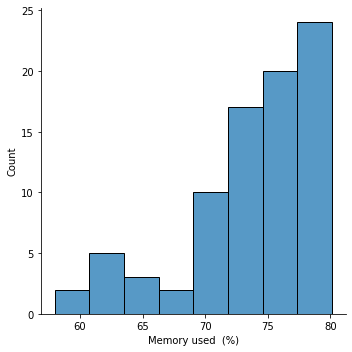

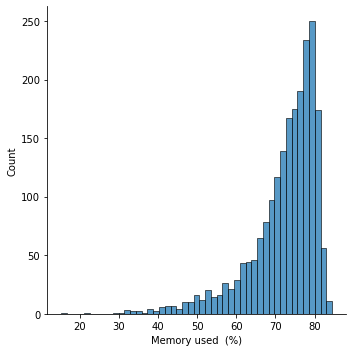

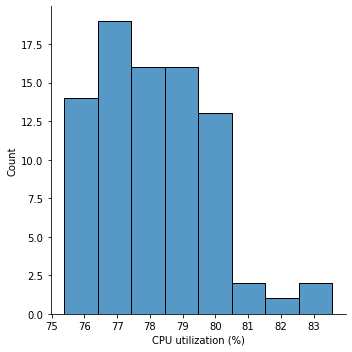

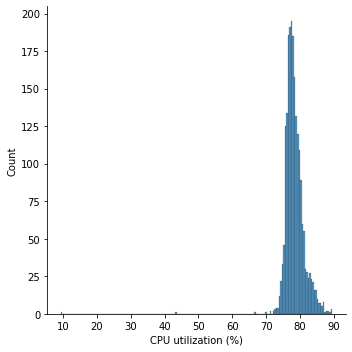

In [8]:
import seaborn as sns

sns.displot(resample_data.loc["2021-09-15":],x="Memory used  (%)")
sns.displot(resample_data.loc[:"2021-09-15"],x="Memory used  (%)")
sns.displot(resample_data.loc["2021-09-15":],x="CPU utilization (%)")
sns.displot(resample_data.loc[:"2021-09-15"],x="CPU utilization (%)")

In [133]:

    
dict_5v = {}
dict_5v_quene = {}
for name in names[4:]:
    dict_5v[name] = data_5v[data_5v['name']==name].values[:,-1]
for name in names[:4]:
    dict_5v_quene[name] = data_5v[data_5v['name']==name].values[:,-1]
    
concat1 = pd.DataFrame(dict_5v,index=ind)
concat2 = pd.DataFrame(dict_5v_quene,index=ind2)
#concat1.to_csv(os.path.join(root_path,"OPTIdata","5v_180day.csv"))
#concat2.to_csv(os.path.join(root_path,"OPTIdata","5v_180day_concat_quene.csv"))

### T-SNE Analysis

In [11]:
df = read_data("./Dataset/OPTIdata/pre_process_withlabel/5v_server_180dayswithanomaly.csv",
          o_dtname="Datetime",
          c_dtname='dt')

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
anomaly_label                              0
dtype: int64


In [13]:
X, y = df.iloc[:,:4].values,df.iloc[:,-1].values
print(X.shape)
print(y.shape)


(90089, 4)
(90089,)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
#Prepare the data


X, y = df.iloc[:,:4].values,df.iloc[:,-1].values

from sklearn.preprocessing import MinMaxScaler,RobustScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(X[:,[0,1]]) 


#t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', 
                       random_state=5, 
                       verbose=1).fit_transform(data_scaled)

#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne-x_min) / (x_max - x_min)  #Normalize


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 90089 samples in 0.064s...
[t-SNE] Computed neighbors for 90089 samples in 1.365s...
[t-SNE] Computed conditional probabilities for sample 1000 / 90089
[t-SNE] Computed conditional probabilities for sample 2000 / 90089
[t-SNE] Computed conditional probabilities for sample 3000 / 90089
[t-SNE] Computed conditional probabilities for sample 4000 / 90089
[t-SNE] Computed conditional probabilities for sample 5000 / 90089
[t-SNE] Computed conditional probabilities for sample 6000 / 90089
[t-SNE] Computed conditional probabilities for sample 7000 / 90089
[t-SNE] Computed conditional probabilities for sample 8000 / 90089
[t-SNE] Computed conditional probabilities for sample 9000 / 90089
[t-SNE] Computed conditional probabilities for sample 10000 / 90089
[t-SNE] Computed conditional probabilities for sample 11000 / 90089
[t-SNE] Computed conditional probabilities for sample 12000 / 90089
[t-SNE] Computed conditional probabilities for sam

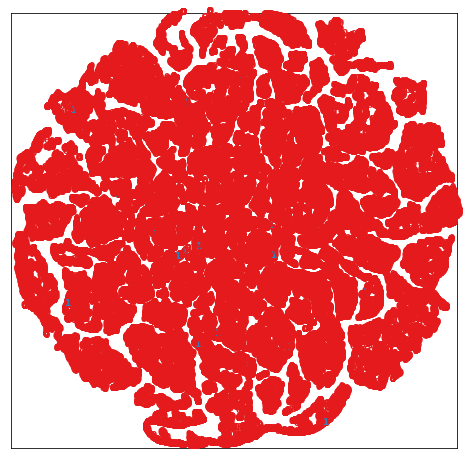

In [27]:
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[-i, 0], X_norm[-i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

### Tsfresh Analysis

### PCA Analysis

### PyOD Analysis